# Acknowledgements
This script is based on https://envisionbox.org/embedded_Gesture_kinematic_spaces.html.

Please cite the following in addition to the citation to our paper when using the script:
- Pouw, W. (2023). Visualizing gesture kinematic spaces. [the day you viewed the site]. Retrieved from: https://envisionbox.org/gesture_kinematic_spaces.html


# Overview processing steps

This markdown file contains the following processing steps.

* Merge body and hands time series and apply normalization and smoothing.

* Merge the timeseries with ELAN annotation

* Create a distance matrix with dynamic time warping distances between events

# Import packages & define directories

In [2]:
# load in some basic packages
import numpy as np                           # basic data operations
import pandas as pd                          # data wrangling
import matplotlib.pyplot as plt              # for plotting
import plotly.graph_objects as go            # for plotting
import html                                  # for html-related add-ons
import os                                    # for foldering       
import glob                                  # for file handling     
from IPython.display import Image            # for showing videos
from scipy.stats import zscore               # for z-scoring
from scipy.ndimage import gaussian_filter1d  # for smoothing
from scipy.spatial import distance           # for Euclidian distance
from statistics import mean                  # for mean
# from scipy.interpolate import CubicSpline    # for interpolation
# from scipy import signal                     # for smoothing
from scipy.stats import ttest_ind            # for two-sample t-test
from scipy.stats import f                    # for F-test
from scipy.stats import levene               # for Levene's test
from tqdm import tqdm                        # for progress bars
import itertools                             # for list combinations
import statsmodels.formula.api as smf        # for linear regression
from warnings import simplefilter            # for ignoring warnings
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)

# load packages for dynamic time warping
from dtw import dtw, dtwPlot

# load custom-made functions
from functions import merge_ts, fill_missing_values, normalize_size, normalize_position, \
    adjust_aspect_ratio, flip_y_axis, export_merge_annot

# initialize some folders and files
timeseries_folder = "../../data/time_series/"
# list of all the folders in the time series folder
ts_folders = os.listdir(timeseries_folder)

anno_path = "../elan_annotation/"
processed_folder = "../processed/"
merged_folder = processed_folder + "01_merged_ts/"
interpolated_folder = processed_folder + "02_interpolated_ts/"
norm_smooth_folder = processed_folder + "03_normalized_and_smoothed_ts/"
ts_annot_folder = processed_folder + "04_ts_with_anno_for_each_comparison/"
dtw_folder = processed_folder + "05_dtw_distance/"
ts_annot_adjusted_folder = processed_folder + "06_ts_with_anno_dur_adjusted/"
dtw_adjusted_folder = processed_folder + "07_dtw_distance_dur_adjusted/"
modified_folder = processed_folder + "08_modified_ts/"
ts_annot_modified_folder = processed_folder + "09_ts_with_anno_modified/"
dtw_modified_folder = processed_folder + "10_dtw_distance_modified/"

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



# Data preparation
## Preprocessing
We will perform the following preprocessing on the timeseries data:

1. merge body and hands time series data into one pandas dataframe
2. interpolate the missing values
3. apply smoothing
4. normalize for size and position
5. adjust for aspect ratio
6. flip y axis

**Why do we interpolate missing values?**

Sometimes, mediapipe fails to estimate the location of a joint and returs no value. This leads to a timeseries with a lot of missing values or NaNs and can cause errors when computing distance using DTW.

To tackle this, we will fill out missing values based on the most adjacent values for the particular keypoint. For example, imagine that the "X_LEFT_THUMB_TIP" consisted of 5 missing values like this: 0.5, 0.4, NaN, NaN, NaN, NaN, NaN, -0.2. In this case, we will fill the NaNs in a way that the value immediately before the first NaN and the one immediately after the last NaN are equally distanced, like this: 0.5, 0.4, 0.3, 0.2, 0.1, 0, -0.1, -0.2. This can offer a reasonable estimate for where the hand was for the missing points.

**Why do we smooth the data?**

We will apply smoothing because most likely, there will be noise-related jitter in the time series data.

**Why do we normalize for size and position?**

We normalize size and position to ensure a consistent representation of poses across different frames and individuals. In other words, normalization reduces noise in the data caused by variation in the location of participant. 

Consider a case where in one video (video A) a participant is standing on the left of the video at 1m from the camera and in another video (video B) the same participant is standing on the right side at 2m from the camera. In this case, values for x-axis is (almost) always lower for video A because of the participant appears on the left in video A while they appear on the right in video B. In addition, the same movements look bigger in video B because the participant is closer to the camera. In this case, applying size and position normalization can "move" the participant to the center of the video so that the difference in standing position does not affect timeseries data.

**Why do we adjust for aspect ratio and flip y-axis?**

We adjust the values for x- and y-axis to align the unit size for x and y. For example, for a video with 16:9 aspect ratio (e.g., 1920:1080), if moving a hand 5 cm horizontally corresponds to 0.1 in x, moving a hand 5 cm vertically corresponds to about 0.18 in y. This difference arises because although the width of video is larger than the height, the range of MediaPipe unit is 0 to 1 for both x and y.

In addition, we will flip the y-axis because mediapipe output unit for y-axis is conterintuitve: 0 means top and 1 means bottom of the frame.

In [ ]:
#load in data
ts_file_list = [timeseries_folder + file_name + "/" + file_name for file_name in ts_folders]
skip_count = 0
existing_files = []
body_cols_to_keep = ["time", 
                     "X_LEFT_SHOULDER", "Y_LEFT_SHOULDER", "Z_LEFT_SHOULDER",
                     "X_RIGHT_SHOULDER", "Y_RIGHT_SHOULDER", "Z_RIGHT_SHOULDER",
                     "X_LEFT_HIP", "Y_LEFT_HIP", "Z_LEFT_HIP",
                     "X_RIGHT_HIP", "Y_RIGHT_HIP", "Z_RIGHT_HIP"]

for file in tqdm(ts_file_list):
    filename = file.split("/")[-1]
    if os.path.exists(norm_smooth_folder + filename + "_ns.csv"):
        skip_count += 1
        existing_files.append(file)
        continue
    
    # # merge body and hands time series
    # merged_df = merge_ts(file, body_cols_to_keep)
    # merged_df.to_csv(merged_folder + filename + "_merged.csv", index=False)
    merged_df = pd.read_csv(merged_folder + filename + "_merged.csv")
    # interpolate missing values
    interpolated_df = fill_missing_values(merged_df)
    interpolated_df.to_csv(interpolated_folder + filename + "_interpolated.csv", index=False) 
    # apply smoothing
    xyz_cols = [col for col in interpolated_df.columns if col.startswith("X_") or col.startswith("Y_") or col.startswith("Z_")]
    smoothed_df = interpolated_df[xyz_cols].apply(lambda x: gaussian_filter1d(x, sigma = 2))
    smoothed_df.insert(0, 'time', interpolated_df["time"])
    # normalize time series
    normalized_df = normalize_size(smoothed_df.copy())
    normalized_df = normalize_position(normalized_df)
    # adjust for aspect ratio
    normalized_df = adjust_aspect_ratio(normalized_df)
    # flip y-axis
    normalized_df = flip_y_axis(normalized_df)
    # save normalized and smoothed time series
    normalized_df.to_csv(norm_smooth_folder + filename + "_ns.csv", index=False)

if skip_count > 0:
    print(f"Skipped {skip_count} files that already exist in the normalized and smoothed folder.")
    print(existing_files)

 68%|██████▊   | 26/38 [53:27<28:17, 141.42s/it] 

Using engine='python' to read the csv files: ../../data/time_series/pair18_synced_ppA/pair18_synced_ppA


 79%|███████▉  | 30/38 [1:01:09<16:44, 125.57s/it]

Using engine='python' to read the csv files: ../../data/time_series/pair21_synced_ppA/pair21_synced_ppA


100%|██████████| 38/38 [1:21:51<00:00, 129.25s/it]

Skipped 1 files that already exist in the normalized and smoothed folder.
['../../data/time_series/pair04_synced_ppA/pair04_synced_ppA']


In [10]:
pair04_merged = pd.read_csv(merged_folder + "pair04_synced_ppA_merged.csv")
pair04_interpolated = pd.read_csv(interpolated_folder + "pair04_synced_ppA_interpolated.csv")
pair04_normalized_smoothed = pd.read_csv(norm_smooth_folder + "pair04_synced_ppA_ns.csv")

(1700.0, 2400.0)

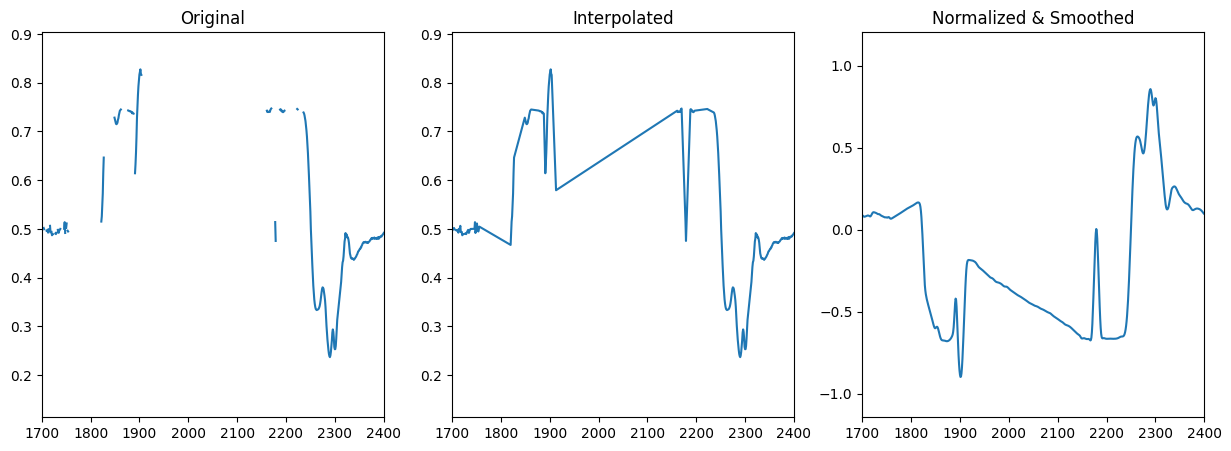

In [11]:
# Create a figure with two subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

ax1.plot(pair04_merged[["Y_LEFT_INDEX_FINGER_TIP"]])
ax1.set_title("Original")
ax1.set_xlim(1700, 2400)
ax2.plot(pair04_interpolated[["Y_LEFT_INDEX_FINGER_TIP"]])
ax2.set_title("Interpolated")
ax2.set_xlim(1700, 2400)
ax3.plot(pair04_normalized_smoothed[["Y_LEFT_INDEX_FINGER_TIP"]])
ax3.set_title("Normalized & Smoothed")
ax3.set_xlim(1700, 2400)

As can be seen in the second plot, the missing values are interpolated linearly. Of course this is not a perfectly accurate estimates for the missing values, but we will use it as a good-enough approximation.

Based on the last figure, it looks like the smoothing was applied successfully. Note that the middle "mountain" observed in the first two plots has disappeared in the last plot. This is not because of smoothing, but because of normalization, suggesting that the body (sholders) moved together with the hand.

## Merging mediapipe time series with ELAN annotations
Now, let's merge mediapipe pose estimation data with ELAN annotations.

In [12]:
annots = os.listdir(anno_path)

### only for validation
for anno_filename in annots:
    if anno_filename == "gesture_form_similarity_coding_original.csv": # only load in the gesture similarity coding file for validation
        anno = pd.read_csv(anno_path + anno_filename, sep=";")
        # if A_begin_msec is smaller than B_begin_msec, then A is the first gesturer
        anno["speaker_1"] = np.where(anno["A_begin_msec"] < anno["B_begin_msec"], "A", "B")
        # if A_begin_msec is smaller than B_begin_msec, then B is the second gesturer
        anno["speaker_2"] = np.where(anno["A_begin_msec"] < anno["B_begin_msec"], "B", "A")
anno.to_csv(anno_path + "gesture_form_similarity_coding.csv", index=False, sep=";")

# load in the annotations for gesture similarity coding
for anno_filename in annots:
    if anno_filename == "gesture_form_similarity_coding.csv": # only load in the gesture similarity coding file for validation
        anno = pd.read_csv(anno_path + anno_filename, sep=";")
        # create a comparison_id column that starts from 1 and increments by 1. This will be used when computing the distance matrix using DTW
        anno["comparison_id"] = anno.index + 1
        # create handedness, position, shape, movement, and orientation columns and fill them with the values from the gesture_similarity_coding column
        # in the gesture similarity coding column, the values are preceded by the category name (e.g. "H1" for handedness with value 1)
        anno["handedness"] = anno["gesture_similarity_coding"].str.extract(r'H(\d)').astype(int)
        anno["position"] = anno["gesture_similarity_coding"].str.extract(r'P(\d)').astype(int)
        anno["shape"] = anno["gesture_similarity_coding"].str.extract(r'S(\d)').astype(int)
        anno["movement"] = anno["gesture_similarity_coding"].str.extract(r'M(\d)').astype(int)
        anno["orientation"] = anno["gesture_similarity_coding"].str.extract(r'R(\d)').astype(int)
        anno["n_hand_A"] = np.where(anno["A_hands"].str.endswith("both"), 2, 1)
        anno["n_hand_B"] = np.where(anno["B_hands"].str.endswith("both"), 2, 1)
        anno["handedness_one_or_both"] = np.where(anno["n_hand_A"] == anno["n_hand_B"], 1, 0)

        # remove 9 from the handedness, position, shape, movement, and orientation columns
        anno["handedness"] = anno["handedness"].replace(9, 0)
        anno["position"] = anno["position"].replace(9, 0)
        anno["shape"] = anno["shape"].replace(9, 0)
        anno["movement"] = anno["movement"].replace(9, 0)
        anno["orientation"] = anno["orientation"].replace(9, 0)

        # compute the total number of features matching between the two gestures
        anno["n_features_original"] = anno["handedness"] + anno["position"] + anno["shape"] + anno["movement"] + anno["orientation"]
        anno["n_features"] = anno["n_features_original"] - anno["handedness"] + anno["handedness_one_or_both"]
        anno["n_features_shape_movement"] = anno["shape"] + anno["movement"]

        # Compute the difference in duration between the two gestures
        anno["duration_diff"] = anno["A_duration_msec"] - anno["B_duration_msec"]
        anno["duration_diff_abs"] = anno["duration_diff"].abs()

        # make a new column and fill it with the adjusted duration
        anno["A_begin_msec_adj"] = np.where(anno["A_duration_msec"] < 330, 
                                            anno["A_begin_msec"] + (anno["A_duration_msec"] - 330)/2, anno["A_begin_msec"])
        anno["A_end_msec_adj"] = np.where(anno["A_duration_msec"] < 330,
                                            anno["A_end_msec"] - (anno["A_duration_msec"] - 330)/2, anno["A_end_msec"])
        anno["A_duration_msec_adj"] = anno["A_end_msec_adj"] - anno["A_begin_msec_adj"]
        anno["B_begin_msec_adj"] = np.where(anno["B_duration_msec"] < 330,
                                            anno["B_begin_msec"] + (anno["B_duration_msec"] - 330)/2, anno["B_begin_msec"])
        anno["B_end_msec_adj"] = np.where(anno["B_duration_msec"] < 330,
                                            anno["B_end_msec"] - (anno["B_duration_msec"] - 330)/2, anno["B_end_msec"])
        anno["B_duration_msec_adj"] = anno["B_end_msec_adj"] - anno["B_begin_msec_adj"]
        anno["min_duration_adj"] = np.minimum(anno["A_duration_msec_adj"], anno["B_duration_msec_adj"])

        # # A & B both -> both; A left & B right -> both; A right & B left -> both; A left & B left -> left; A right & B right -> right
        # anno["hands_dtw"] = np.where((anno["A_hands"].str.endswith("left")) & (anno["B_hands"].str.endswith("left")), "left",
        #                                 np.where((anno["A_hands"].str.endswith("right")) & (anno["B_hands"].str.endswith("right")), "right", "both"))
        # A & B both -> both; A left & B right -> left_right; A right & B left -> right_left; A left & B left -> left; A right & B right -> right
        anno["hands_dtw"] = np.where((anno["A_hands"].str.endswith("left")) & (anno["B_hands"].str.endswith("left")), "left",
                                        np.where((anno["A_hands"].str.endswith("right")) & (anno["B_hands"].str.endswith("right")), "right", 
                                                np.where((anno["A_hands"].str.endswith("left")) & (anno["B_hands"].str.endswith("right")), "left_right",
                                                        np.where((anno["A_hands"].str.endswith("right")) & (anno["B_hands"].str.endswith("left")), "right_left", "both"))))

anno.head()
anno.to_csv(anno_path + "gesture_form_similarity_coding_processed.csv", index=False)

In [13]:
pd.options.mode.copy_on_write = True # to avoid the SettingWithCopyWarning

# this function loads in annotations and the original time of the timeseries dataframe, and returns annotations for the time series dataframe
def load_in_event(time_original, adata, col, speaker, i):
    output = np.full(len(time_original), np.nan, dtype=object)  # Initialize output array with NaN values
    if speaker == 'A':
        # Assign the annotation if the time is between the begin and end time of the annotation 
        output[(time_original >= adata.loc[i, 'A_begin_msec']) & (time_original <= adata.loc[i, 'A_end_msec'])] = adata.iloc[i, adata.columns.get_loc(col)]
    elif speaker == 'B':
        output[(time_original >= adata.loc[i, 'B_begin_msec']) & (time_original <= adata.loc[i, 'B_end_msec'])] = adata.iloc[i, adata.columns.get_loc(col)] 
    
    return output


def export_merge_annot(MT_files, anno, ts_annot_folder):
    # merged_data_list = []
    merged_data = pd.DataFrame()  # Initialize an empty DataFrame

    n_comparisons = len(anno) #this should be 419
    print("Number of comparisons: " + str(n_comparisons))

    skip_count = 0
    skip_files = []

    for mt_file in tqdm(MT_files):
        fname = os.path.basename(mt_file).split('_ns')[0]
        # check if the processed file already exists
        if glob.glob(ts_annot_folder + fname + "*.csv"):
            skip_count += 1
            skip_files.append(fname)
            continue # Skip the file if it already exists. 

        speaker = fname.split('pp')[1] # Extract the speaker from the file name
        pair_n = int(fname.split('pair')[1].split('_')[0]) # Extract the pair number from the file name and convert it to an integer
        if pair_n not in anno['pairnr'].values:
            # print("Pair number " + str(pair_n) + " not found in the annotation file.")
            continue

        # print("Now processing: " + mt_file + " for speaker " + speaker + "...")
        mdata = pd.read_csv(mt_file)
        adata = anno[anno['pairnr'] == pair_n].reset_index(drop=True)
        merged_data_cols = list(mdata.columns)
        merged_data = mdata[merged_data_cols]
        

        cols = ["comparison_id"]

        for i in range(len(adata)):
            comparison_id = adata.loc[i, 'comparison_id']
            # Initialize a pandas dataframe and a dictionary to hold new columns (this approach is faster than appending to a DataFrame in a loop)
            new_cols_df = pd.DataFrame()
            new_cols = {}
            # Add the new column to the dictionary
            new_cols['File'] = [fname] * len(merged_data)
            new_cols['Speaker'] = [speaker] * len(merged_data)

            # Apply the function to each column and store the result in the dictionary
            for col in cols:
                new_cols[col] = load_in_event(merged_data['time'], adata, col, speaker, i)

            # Create a new DataFrame from the dictionary
            new_cols_df = pd.DataFrame(new_cols)
            # Concatenate the original DataFrame with the new DataFrame
            final_merged_data = pd.concat([merged_data, new_cols_df], axis=1)
            final_merged_data = final_merged_data[final_merged_data['comparison_id'].notna()]
            # export the merged data to a csv file
            final_merged_data.to_csv(ts_annot_folder + fname + "_" + str(comparison_id) + ".csv", index=False)
            # merged_data_list.append(merged_data)
        
    # # Concatenate all DataFrames in the list into one DataFrame
    # final_merged_data = pd.concat(merged_data_list, ignore_index=True)


MT_files = glob.glob(norm_smooth_folder + "*.csv")
# MT_files = MT_files[2:4]  # for testing purposes
anno = pd.read_csv(anno_path + "gesture_form_similarity_coding_processed.csv")

export_merge_annot(MT_files, anno, ts_annot_folder)

Number of comparisons: 419


100%|██████████| 38/38 [01:02<00:00,  1.63s/it]


Now we have timeseries file for each gesture comparison pair.


# Compute distance using DTW
Next, we will compute distance matrix for each gesture comparison pair (distance between gesture 1 and gesture 2) to measure (dis)similarity of two gestures.

But before analyzing the real data, let's check how DTW works with simulated data.

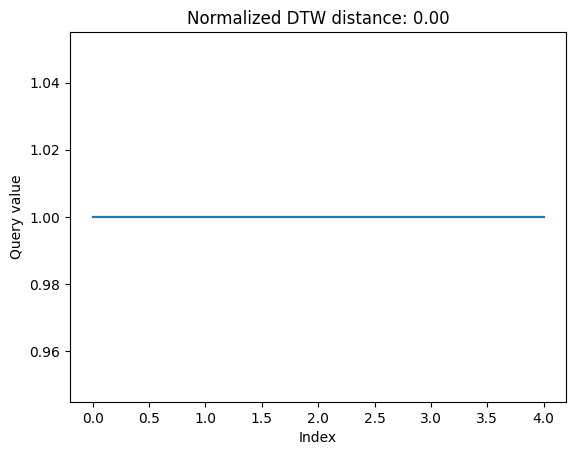

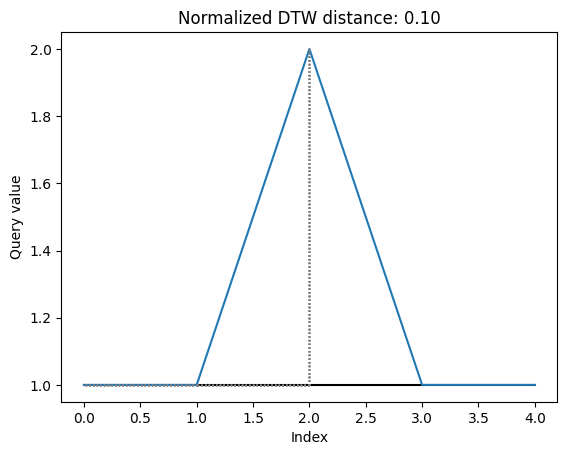

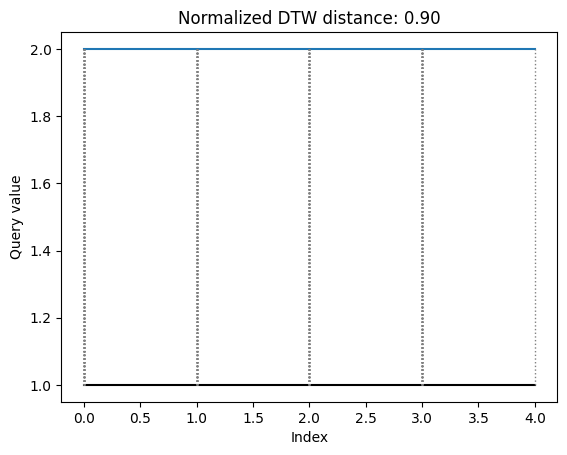

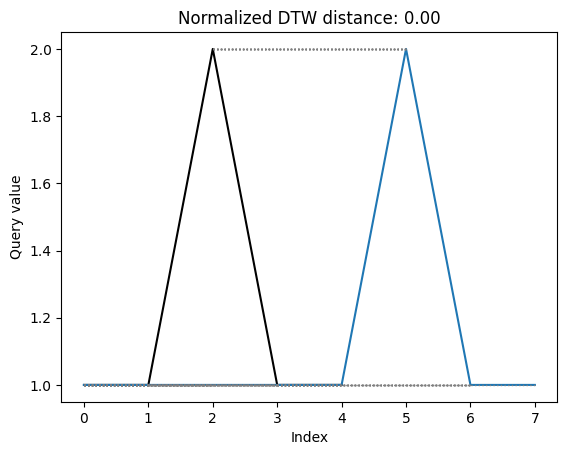

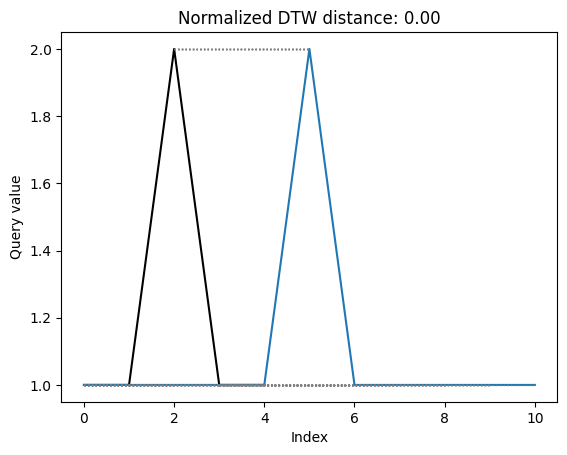

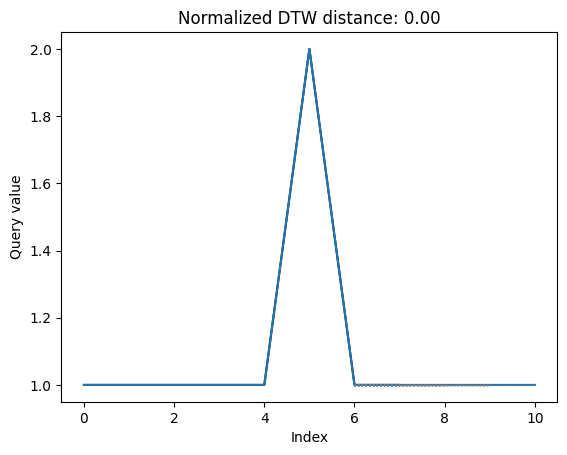

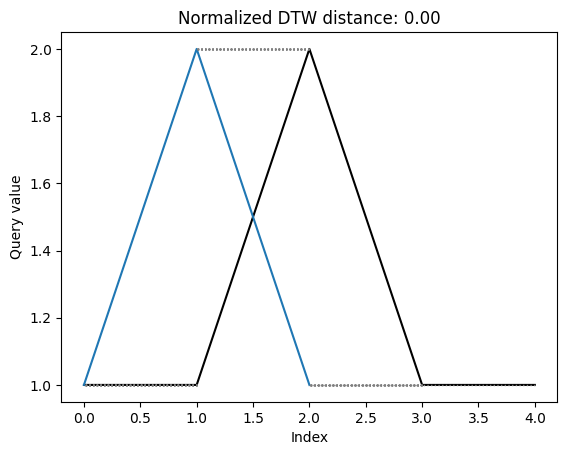

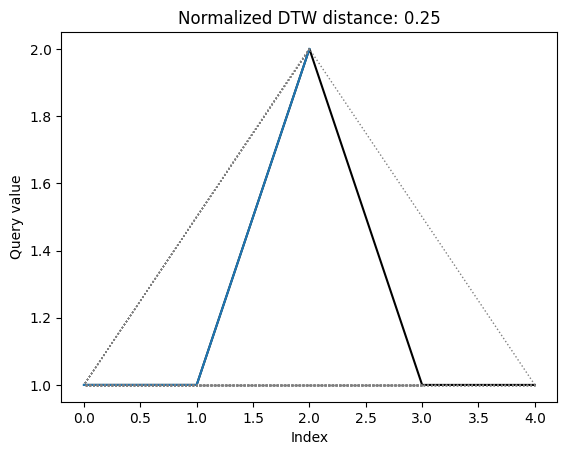

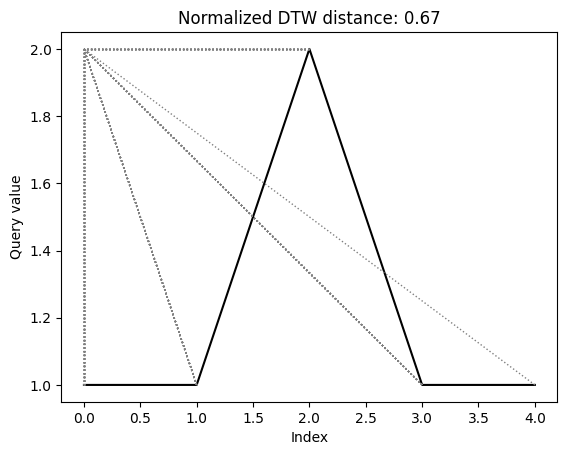

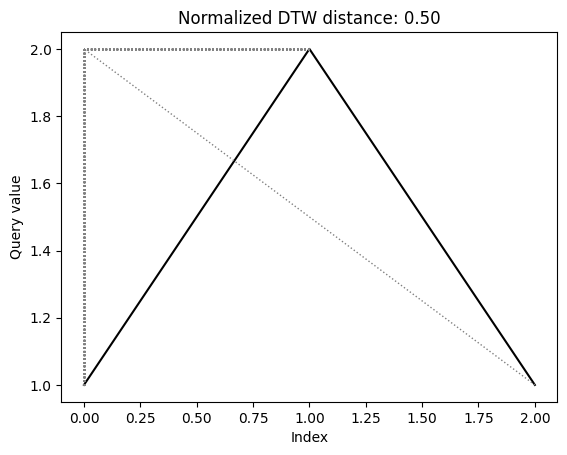

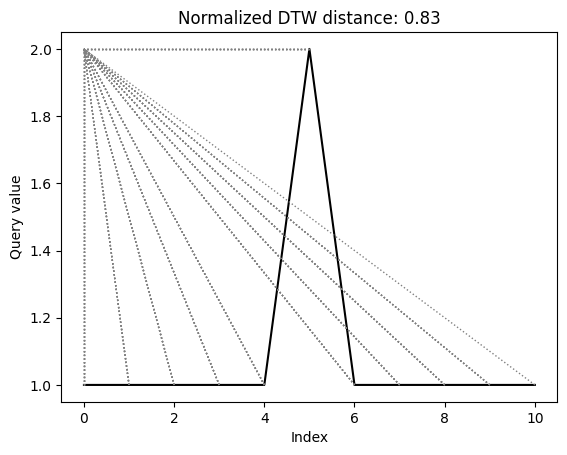

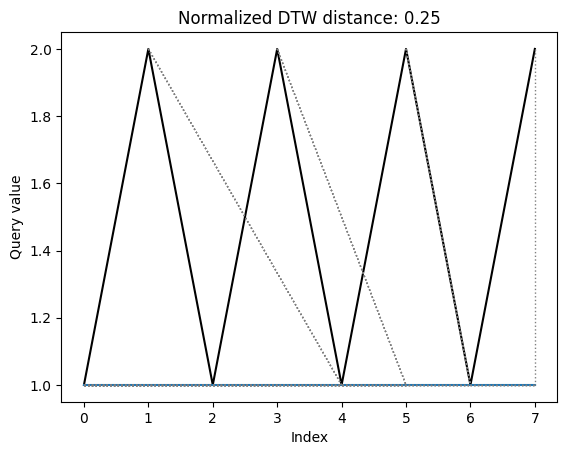

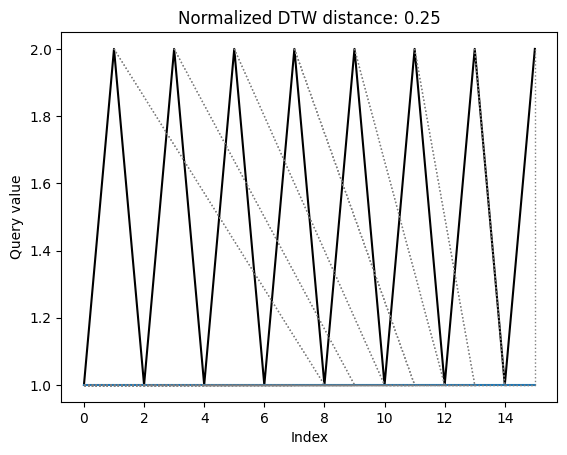

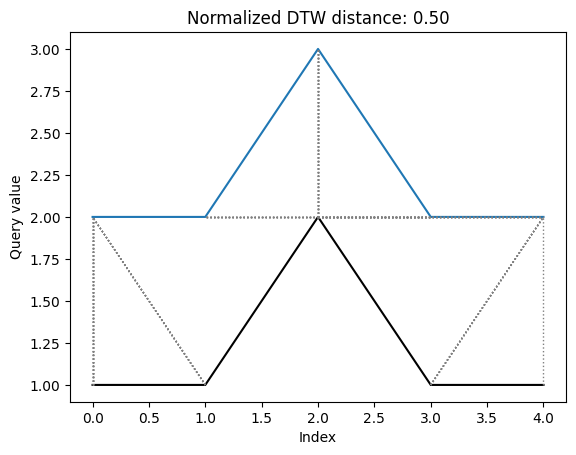

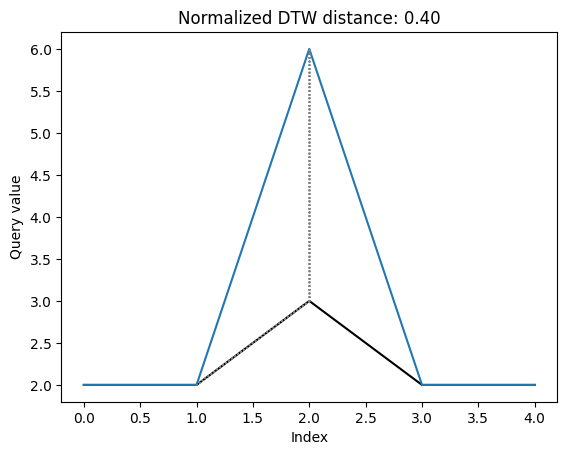

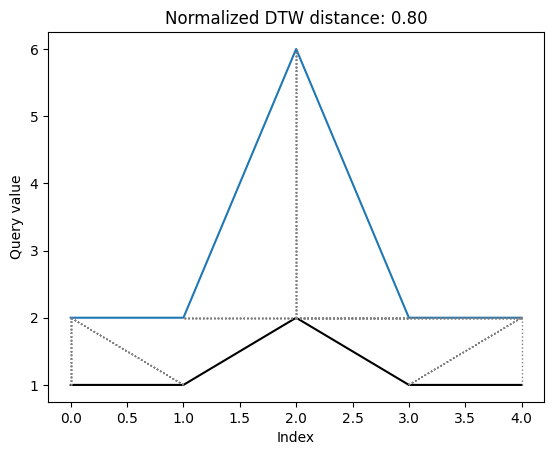

In [14]:
# compute the distance using DTW
def compute_dtw(ts1, ts2):
    window_size = min(len(ts1), len(ts2)) // 10 # the window size is 10% of the length of the shortest timeseries
    if window_size < 3:
        window_size = 3 # the window size should be at least 3 frames

    res = dtw(ts1, ts2, 
                keep_internals = True,
                step_pattern = "symmetric2",
                window_args= {"window_type": "sakoechiba", "window_size": window_size})
    dis_normalized = res.normalizedDistance
    # add the result as the title of the plot
    dtwPlot(res, type="twoway")
    plt.title(f"Normalized DTW distance: {dis_normalized:.2f}")

# simulate time series data
sim_ts_1 = np.array([1, 1, 1, 1, 1])
sim_ts_2 = np.array([1, 1, 2, 1, 1])
sim_ts_3 = np.array([2, 2, 2, 2, 2])
sim_ts_4 = np.array([1, 1, 1, 1, 1, 2, 1, 1]) # three 1s added in the beginning of sim_ts_2
sim_ts_5 = np.array([1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1]) # three 1s added in the beginning and the ending of sim_ts_1
sim_ts_6 = np.array([1, 2, 1])
sim_ts_7 = np.array([1, 1, 2])
sim_ts_8 = np.array([2])
sim_ts_9a = np.array([1, 2, 1, 2, 1, 2, 1, 2])
sim_ts_9b = np.array([1, 1, 1, 1, 1, 1, 1, 1])
sim_ts_10a = np.array([1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2])
sim_ts_10b = np.array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
sim_ts_11 = np.array([2, 2, 3, 2, 2])
sim_ts_12 = np.array([2, 2, 6, 2, 2])

#============ identical ts ============
compute_dtw(sim_ts_1, sim_ts_1)

#============ ts with same values but different pattern ============
compute_dtw(sim_ts_1, sim_ts_2)

#============ ts with different values but identical pattern ============
compute_dtw(sim_ts_1, sim_ts_3)

#============ ts with different lengths ============
compute_dtw(sim_ts_2, sim_ts_4)
compute_dtw(sim_ts_2, sim_ts_5)
compute_dtw(sim_ts_4, sim_ts_5)
compute_dtw(sim_ts_2, sim_ts_6)
compute_dtw(sim_ts_2, sim_ts_7)
compute_dtw(sim_ts_2, sim_ts_8)
compute_dtw(sim_ts_6, sim_ts_8)
compute_dtw(sim_ts_5, sim_ts_8)

#============ ts with same lengths but different patterns ============
compute_dtw(sim_ts_9a, sim_ts_9b)
compute_dtw(sim_ts_10a, sim_ts_10b)

#============ ts with same pattern but different values ============
compute_dtw(sim_ts_2, sim_ts_11)
compute_dtw(sim_ts_11, sim_ts_12)

#============ ts with different patterns and different values ============
compute_dtw(sim_ts_2, sim_ts_12)

The above comparisons highlights a few important things to note when using DTW:

1. When two time series match exactly, the distance will be 0 (comparison 1).
1. When two time series match on the pattern (e.g., always 1 or 2) but differ in the values, the distance will still be large (comparison 3).
1. When a longer time series contains the same sequence as a shorter time series, and the adjacent sequences of the longer ts have the same values as the first/last value of the shorter ts, the distance will be 0 (comparison 4, 5, 6)
1. However, even if a longer time series contains the same sequence as a shorter time series, if the adjacent sequences of the longer ts don't have the same values as the first/last values of the shorter ts, the distance won't be 0 (comparison 7--11).
1. DTW seems to be more sensitive to the values than the patterns. This suggests that DTW is very senstive to difference in location of gestures but not so much in movements, although we want it to be more sensitive to movements and less so for location.

To summarize, DTW is sensitive to the value, pattern, and duration difference (only when the beginning and the ending of two ts are different).

We'll first perform DTW on raw time series data.

## DTW on raw time series

In [15]:
# identify which column indices in a dataframe correspond to which body parts
keypoint_thumb_right = ["X_RIGHT_THUMB_TIP", "Y_RIGHT_THUMB_TIP", "Z_RIGHT_THUMB_TIP"]
keypoint_thumb_left = ["X_LEFT_THUMB_TIP", "Y_LEFT_THUMB_TIP", "Z_LEFT_THUMB_TIP"]
keypoint_index_right =  ["X_RIGHT_INDEX_FINGER_TIP", "Y_RIGHT_INDEX_FINGER_TIP", "Z_RIGHT_INDEX_FINGER_TIP"]
keypoint_index_left = ["X_LEFT_INDEX_FINGER_TIP", "Y_LEFT_INDEX_FINGER_TIP", "Z_LEFT_INDEX_FINGER_TIP"]
keypoint_middle_right = ["X_RIGHT_MIDDLE_FINGER_TIP", "Y_RIGHT_MIDDLE_FINGER_TIP", "Z_RIGHT_MIDDLE_FINGER_TIP"]
keypoint_middle_left = ["X_LEFT_MIDDLE_FINGER_TIP", "Y_LEFT_MIDDLE_FINGER_TIP", "Z_LEFT_MIDDLE_FINGER_TIP"]
keypoint_ring_right = ["X_RIGHT_RING_FINGER_TIP", "Y_RIGHT_RING_FINGER_TIP", "Z_RIGHT_RING_FINGER_TIP"]
keypoint_ring_left = ["X_LEFT_RING_FINGER_TIP", "Y_LEFT_RING_FINGER_TIP", "Z_LEFT_RING_FINGER_TIP"]
keypoint_pinky_right =  ["X_RIGHT_PINKY_FINGER_TIP", "Y_RIGHT_PINKY_FINGER_TIP", "Z_RIGHT_PINKY_FINGER_TIP"]
keypoint_pinky_left = ["X_LEFT_PINKY_FINGER_TIP", "Y_LEFT_PINKY_FINGER_TIP", "Z_LEFT_PINKY_FINGER_TIP"]
keypoint_wrist_right = ["X_RIGHT_WRIST", "Y_RIGHT_WRIST", "Z_RIGHT_WRIST"]
keypoint_wrist_left = ["X_LEFT_WRIST", "Y_LEFT_WRIST", "Z_LEFT_WRIST"]

# make one 1 list with all keypoints
keypoints = list(itertools.chain(keypoint_thumb_right, keypoint_thumb_left, 
                                 keypoint_index_right, keypoint_index_left, 
                                 keypoint_middle_right, keypoint_middle_left, 
                                 keypoint_ring_right, keypoint_ring_left, 
                                 keypoint_pinky_right, keypoint_pinky_left, 
                                 keypoint_wrist_right, keypoint_wrist_left))


#make a function that takes in two timeseries and produces a normalized dtw distance
def dtw_distance_normalized(ts1, ts2):
    ts1 = np.array(ts1)
    ts2 = np.array(ts2)

    window_size = min(len(ts1), len(ts2)) // 10 # the window size is 10% of the length of the shortest timeseries
    if window_size < 3:
        window_size = 3 # the window size should be at least 3 frames

    res = dtw(ts1, ts2, 
                keep_internals = True,
                step_pattern = "symmetric2",
                window_args= {"window_type": "sakoechiba", "window_size": window_size})
    normalized_distance = res.normalizedDistance
    
    return normalized_distance


# make a dependent dtw such that each keypoint dtw distance is added up and divided by the number of keypoints
def dtw_distance_dependent(MT1, MT2, distance_array):
    dis_left_thumb = dtw_distance_normalized(MT1[keypoint_thumb_left], MT2[keypoint_thumb_left])
    dis_right_thumb = dtw_distance_normalized(MT1[keypoint_thumb_right], MT2[keypoint_thumb_right])
    dis_left_index = dtw_distance_normalized(MT1[keypoint_index_left], MT2[keypoint_index_left])
    dis_right_index = dtw_distance_normalized(MT1[keypoint_index_right], MT2[keypoint_index_right])
    dis_left_middle = dtw_distance_normalized(MT1[keypoint_middle_left], MT2[keypoint_middle_left])
    dis_right_middle = dtw_distance_normalized(MT1[keypoint_middle_right], MT2[keypoint_middle_right])
    dis_left_ring = dtw_distance_normalized(MT1[keypoint_ring_left], MT2[keypoint_ring_left])
    dis_right_ring = dtw_distance_normalized(MT1[keypoint_ring_right], MT2[keypoint_ring_right])
    dis_left_pinky = dtw_distance_normalized(MT1[keypoint_pinky_left], MT2[keypoint_pinky_left])
    dis_right_pinky = dtw_distance_normalized(MT1[keypoint_pinky_right], MT2[keypoint_pinky_right])
    dis_left_wrist = dtw_distance_normalized(MT1[keypoint_wrist_left], MT2[keypoint_wrist_left])
    dis_right_wrist = dtw_distance_normalized(MT1[keypoint_wrist_right], MT2[keypoint_wrist_right])
    
    #also compute a distance between hands
    # dis_between_hands = dtw_distance_normalized(np.array((MT1[keypoint_index_left])-np.array(MT1[keypoint_index_right])), 
    #                                             (np.array(MT2[keypoint_index_left])-np.array(MT2[keypoint_index_right])))
    
    #compute the average distance
    distance = (dis_left_thumb + dis_right_thumb + dis_left_index + dis_right_index + dis_left_middle + 
                dis_right_middle + dis_left_ring + dis_right_ring + dis_left_pinky + 
                dis_right_pinky + dis_left_wrist + dis_right_wrist) / 12

    #make a np array and append the each distance to the dataframe
    distance_array = np.append(distance_array, 
                               [distance, dis_left_thumb, dis_right_thumb, 
                               dis_left_index, dis_right_index, 
                               dis_left_middle, dis_right_middle, 
                               dis_left_ring, dis_right_ring, 
                               dis_left_pinky, dis_right_pinky, 
                               dis_left_wrist, dis_right_wrist])

    return distance_array


def make_export_dtw_df(dtw_folder, ts_annot_folder, keypoints, anno):
    # make an empty dataframe to store the results
    df_distance = pd.DataFrame(columns=["pair", "comparison_id", "average_distance",
                                        "left_thumb", "right_thumb", "left_index", "right_index", 
                                        "left_middle", "right_middle", "left_ring", "right_ring", 
                                        "left_pinky", "right_pinky", "left_wrist", "right_wrist"])
    df_distance_z = df_distance.copy()

    # specify columns we want to keep in the timeseries dataframe (before merging with annotations)
    cols_to_keep = ["File", "Speaker", "comparison_id", "time"]
    cols_to_keep.extend(keypoints)

    # using dtw to compare distances and show a warping line
    if os.path.exists(dtw_folder + "dtw_distance.csv"):
        print("DTW distance file already exists.")
    else:
        ts_annot_files = [file for file in os.listdir(ts_annot_folder) if file.endswith(".csv")]
        for filename in tqdm(ts_annot_files):
            pair = filename.split("_")[0]
            speaker = filename.split("_")[2]
            comparison_id = filename.split("_")[3].split(".")[0]
            distance_array = np.array([pair, comparison_id])
            distance_array_z = np.array([pair, comparison_id])

            if speaker == "ppB":
                continue
            else:
                MT1 = pd.read_csv(ts_annot_folder + filename)
                MT2 = pd.read_csv(ts_annot_folder + pair + "_synced_ppB_" + comparison_id + ".csv")
                # select only the columns that we want to keep
                MT1 = MT1[cols_to_keep]
                MT2 = MT2[cols_to_keep]
                MT1_z = MT1.copy()
                MT2_z = MT2.copy()
                try:
                    distance_array = dtw_distance_dependent(MT1, MT2, distance_array)
                    df_distance = pd.concat([df_distance, pd.DataFrame([distance_array], columns=df_distance.columns)])
                except:
                    # print(f"[DTW]Error in: {filename}. The file might contain missing values for the keypoints or have too few datapoints. Skipping this file...")
                    pass # do nothing and continue to the next line

                try:
                    # zscore the time series for keypoints columns and submit them to the dtw
                    MT1_z[keypoints] = MT1_z[keypoints].apply(zscore)
                    MT2_z[keypoints] = MT2_z[keypoints].apply(zscore)
                    distance_array_zscore = dtw_distance_dependent(MT1_z, MT2_z, distance_array_z)
                    df_distance_z = pd.concat([df_distance_z, pd.DataFrame([distance_array_zscore], columns=df_distance_z.columns)])
                except:
                    # print(f"[DTW_z]Error in: {filename}. The file might contain missing values for the keypoints or have too few datapoints. Skipping this file...")
                    pass


        # sort the dataframe by comparison_id
        df_distance["comparison_id"] = df_distance["comparison_id"].astype(int)
        df_distance = df_distance.sort_values(by=["comparison_id"])
        df_distance_z["comparison_id"] = df_distance_z["comparison_id"].astype(int)
        df_distance_z = df_distance_z.sort_values(by=["comparison_id"])

        df_distance = pd.merge(df_distance, anno, on="comparison_id", how="left")
        df_distance_z = pd.merge(df_distance_z, anno, on="comparison_id", how="left")

        # save the dataframe to a csv file
        df_distance.to_csv(dtw_folder + "dtw_distance.csv", index=False)
        df_distance_z.to_csv(dtw_folder + "dtw_distance_z.csv", index=False)

        # check the shape of the dataframe
        print(df_distance.shape)
        print(df_distance_z.shape)

In [16]:
anno = pd.read_csv(anno_path + "gesture_form_similarity_coding_processed.csv")
make_export_dtw_df(dtw_folder, ts_annot_folder, keypoints, anno)

100%|██████████| 838/838 [00:46<00:00, 18.14it/s] 


(390, 65)
(389, 65)


### Data visualization (raw time series)

Let's visualize the data and see if the distance negatively correlates with the number of features overlapping.

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm

df_dtw = pd.read_csv(dtw_folder + "dtw_distance.csv")
df_dtw_z = pd.read_csv(dtw_folder + "dtw_distance_z.csv")

def plot_one_feature(df, feature, y):
    plt.figure(figsize=(5, 4))
    sns.set_theme(style="whitegrid")
    sns.violinplot(x=feature, y=y, data=df)
    plt.title(feature)
    plt.ylabel("Average normalized DTW distance")
    plt.xticks([0, 1], ["Not similar", "Similar"])
    plt.show()

def plot_nfeatures(df, feature, y):
    plt.figure(figsize=(5, 4))
    sns.set_theme(style="whitegrid")
    sns.violinplot(x=feature, y=y, data=df)
    plt.title(feature)
    plt.xlabel("Number of features matched")
    plt.ylabel("Average normalized DTW distance")
    plt.show()

def plot_average_distance_dur_diff(df):
    # run a linear regression to see if there is a relationship between the duration difference and the average distance
    x = df["duration_diff_abs"]
    y = df["average_distance"]
    model = sm.OLS(y, x).fit()
    plt.figure(figsize=(5, 4))
    sns.set_theme(style="whitegrid")
    sns.regplot(x="duration_diff_abs", y="average_distance", data=df)
    plt.title("Distance by duration difference")
    plt.xlabel("Difference in duration (ms)")
    plt.ylabel("Average normalized DTW distance")
    plt.show()
    print(model.summary())

def plot_average_distance_dur(df):
    # run a linear regression to see if there is a relationship between the duration difference and the average distance
    x = df["min_duration_adj"]
    y = df["average_distance"]
    model = sm.OLS(y, x).fit()
    plt.figure(figsize=(5, 4))
    sns.set_theme(style="whitegrid")
    sns.regplot(x="min_duration_adj", y="average_distance", data=df)
    plt.title("Distance by minimum duration")
    plt.xlabel("Minimum duration (ms)")
    plt.ylabel("Average normalized DTW distance")
    plt.show()
    print(model.summary())

def plot_average_distance_feature(fig, cols, rows, features, df, y="average_distance"):
    for i in range(len(features)):
        fig.add_subplot(rows, cols, i+1)
        sns.violinplot(x=features[i], y=y, data=df)
        plt.xlabel("")
        plt.title(features[i])
        plt.xticks([0, 1], ["Not similar", "Similar"])
        if i == 0 or i == 3:
            plt.ylabel("Average normalized DTW distance")
        else:  
            plt.ylabel("")
    plt.show()


def plot_average_distance_nfeatures(fig, cols, rows, features, df, y="average_distance"):
    for i in range(len(features)):
        fig.add_subplot(rows, cols, i+1)
        sns.violinplot(x=features[i], y=y, data=df)
        plt.xlabel("Number of features matched")
        plt.title(features[i])
        plt.ylabel("Average normalized DTW distance")
    plt.show()

====================Average distance====================


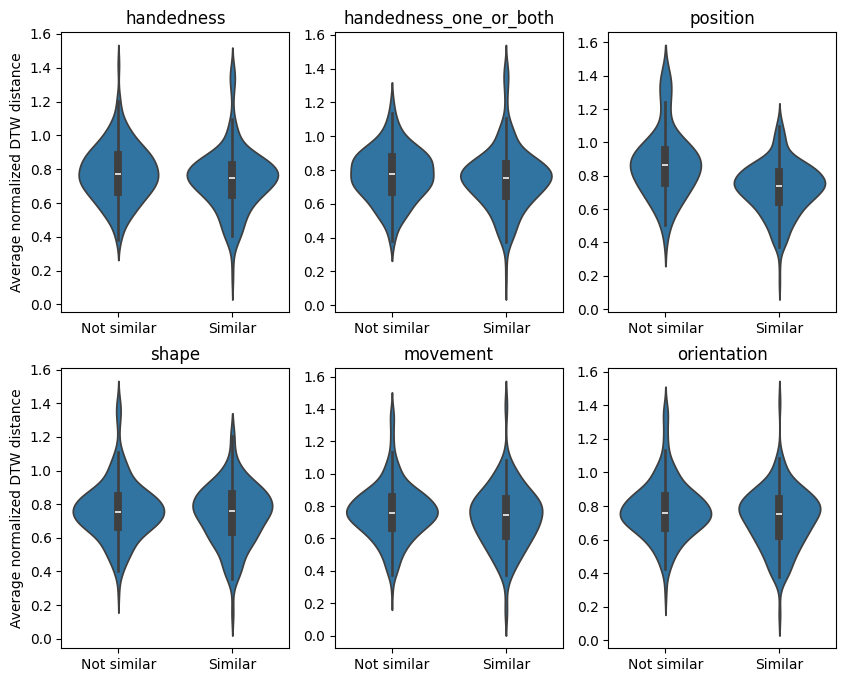

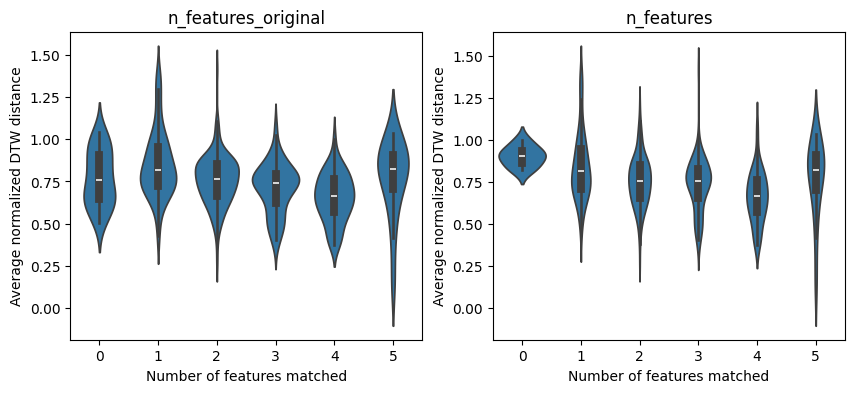

====================Duration difference====================


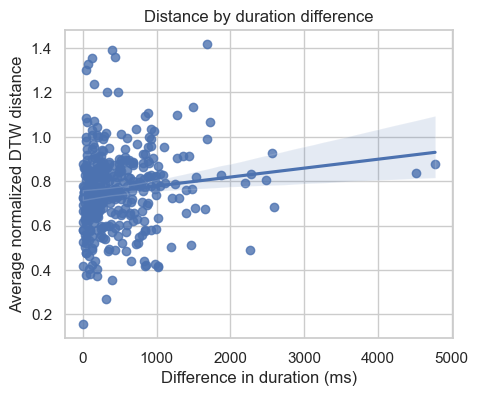

                                 OLS Regression Results                                
Dep. Variable:       average_distance   R-squared (uncentered):                   0.428
Model:                            OLS   Adj. R-squared (uncentered):              0.427
Method:                 Least Squares   F-statistic:                              291.2
Date:                Thu, 15 May 2025   Prob (F-statistic):                    3.90e-49
Time:                        00:03:13   Log-Likelihood:                         -346.13
No. Observations:                 390   AIC:                                      694.3
Df Residuals:                     389   BIC:                                      698.2
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                        coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------

In [18]:
image_folder = dtw_folder + "images/"
### plot the average distance
print("====================" + "Average distance" + "====================")
# plot_one_feature(image_folder, df_dtw, "handedness", "average_distance")
# plot_one_feature(image_folder, df_dtw, "handedness_one_or_both", "average_distance")
# plot_one_feature(image_folder, df_dtw, "position", "average_distance")
# plot_one_feature(image_folder, df_dtw, "shape", "average_distance")
# plot_one_feature(image_folder, df_dtw, "movement", "average_distance")
# plot_one_feature(image_folder, df_dtw, "orientation", "average_distance")

### plot the average distance for each feature
fig = plt.figure(figsize=(10, 8))
columns = 3
rows = 2
features = ["handedness", "handedness_one_or_both", "position", "shape", "movement", "orientation"]
plot_average_distance_feature(fig, columns, rows, features, df_dtw)

### plot the average distance by the number of features matched
fig = plt.figure(figsize=(10, 4))
columns = 2
rows = 1
features = ["n_features_original", "n_features"]
plot_average_distance_nfeatures(fig, columns, rows, features, df_dtw)

### plot the duration
print("====================" + "Duration difference" + "====================")
# plot_one_feature(df_dtw, "handedness", "duration_diff_abs")
# plot_one_feature(df_dtw, "handedness_one_or_both", "duration_diff_abs")
# plot_one_feature(df_dtw, "position", "duration_diff_abs")
# plot_one_feature(df_dtw, "shape", "duration_diff_abs")
# plot_one_feature(df_dtw, "movement", "duration_diff_abs")
# plot_one_feature(df_dtw, "orientation", "duration_diff_abs")
# plot_nfeatures(df_dtw, "n_features_original", "duration_diff_abs")
# plot_nfeatures(df_dtw, "n_features", "duration_diff_abs")
plot_average_distance_dur_diff(df_dtw)

The distance captured by DTW doesn't seem to negatively correlate with the number of features matching. This suggests that curret DTW isn't sensitive enough to capture the gesture form similarity.

Based on the last plot, this could be due to the difference in the duration of two time series, as there was a significantly positive correlation between the difference in duration (ms) between two gestures and the distance. Similar pattern was observed in the simulation too.

To tackle this issue, we will next align the duration of two gestures by lengthening the duration of the shorter gesture.

## DTW on time series with adjusted duration
### Align the duration of two gestures
Here, we will lengthen the duration of the shorter gesture by adding the half of the duration_diff_abs to the beginning and the end of the segmentation. In other words, we will subtract the half of the duration_diff_abs from the X_begin_msec and add it to the X_end_msec.

In [19]:
# load in the annotations for gesture similarity coding
anno = pd.read_csv(anno_path + "gesture_form_similarity_coding_processed.csv")

# make a new column and fill it with the adjusted duration
# if the duration difference is negative, then the duration of the first gesture is longer than the second gesture
# if the duration difference is positive, then the duration of the second gesture is longer than the first gesture
anno["A_begin_msec_aligned"] = np.where(anno["duration_diff"] < 0, 
                                    anno["A_begin_msec"] - anno["duration_diff_abs"]/2, anno["A_begin_msec"])
anno["A_end_msec_aligned"] = np.where(anno["duration_diff"] < 0,
                                  anno["A_end_msec"] + anno["duration_diff_abs"]/2, anno["A_end_msec"])
anno["B_begin_msec_aligned"] = np.where(anno["duration_diff"] > 0, 
                                    anno["B_begin_msec"] - anno["duration_diff_abs"]/2, anno["B_begin_msec"])
anno["B_end_msec_aligned"] = np.where(anno["duration_diff"] > 0,
                                  anno["B_end_msec"] + anno["duration_diff_abs"]/2, anno["B_end_msec"])
anno["A_duration_msec_aligned"] = anno["A_end_msec_aligned"] - anno["A_begin_msec_aligned"]

anno.to_csv(anno_path + "gesture_form_similarity_coding_processed.csv", index=False)
anno.head()

,round,target,A_LH_referent,A_RH_referent,B_LH_referent,B_RH_referent,gesture_similarity_coding,A_begin_hmsm,A_begin_msec,A_end_hmsm,...,B_begin_msec_adj,B_end_msec_adj,B_duration_msec_adj,min_duration_adj,hands_dtw,A_begin_msec_aligned,A_end_msec_aligned,B_begin_msec_aligned,B_end_msec_aligned,A_duration_msec_aligned
0,R1-R2,16,16A+16C,16A+16C,16A+16C,16A+16C,H1P0S0M0R0,00:02:46.435,166435,00:02:47.595,...,520292.0,521012.0,720.0,720.0,both,166435.0,167595.0,520072.0,521232.0,1160.0
1,R1-R2,16,16A+16C,16A+16C,16A+16C,16A+16C,H1P0S0M0R0,00:02:50.417,170417,00:02:51.539,...,520292.0,521012.0,720.0,720.0,both,170417.0,171539.0,520091.0,521213.0,1122.0
2,R1-R2,16,NaN,16A+16C,16A+16C,16A+16C,H0P0S9M0R1,00:02:52.693,172693,00:02:52.933,...,520292.0,521012.0,720.0,330.0,both,172453.0,173173.0,520292.0,521012.0,720.0
3,R1-R2,16,NaN,16A,16A+16C,16A+16C,H0P0S1M0R1,00:02:54.881,174881,00:02:55.087,...,520292.0,521012.0,720.0,330.0,both,174624.0,175344.0,520292.0,521012.0,720.0
4,R1-R2,16,16C,NaN,16A+16C,16A+16C,H0P0S0M0R0,00:02:56.611,176611,00:02:56.754,...,520292.0,521012.0,720.0,330.0,both,176322.5,177042.5,520292.0,521012.0,720.0


In [20]:
# this function loads in annotations and the original time of the timeseries dataframe, and returns annotations for the time series dataframe
def load_in_event(time_original, adata, col, speaker, i):
    output = np.full(len(time_original), np.nan, dtype=object)  # Initialize output array with NaN values
    if speaker == 'A':
        # Assign the annotation if the time is between the begin and end time of the annotation 
        output[(time_original >= adata.loc[i, 'A_begin_msec_aligned']) & (time_original <= adata.loc[i, 'A_end_msec_aligned'])] = adata.iloc[i, adata.columns.get_loc(col)]
    elif speaker == 'B':
        output[(time_original >= adata.loc[i, 'B_begin_msec_aligned']) & (time_original <= adata.loc[i, 'B_end_msec_aligned'])] = adata.iloc[i, adata.columns.get_loc(col)] 
    
    return output


ts_annot_folder = processed_folder + "06_ts_with_anno_dur_adjusted/"
MT_files = glob.glob(norm_smooth_folder + "*.csv")
# MT_files = MT_files[2:4]  # for testing purposes
anno = pd.read_csv(anno_path + "gesture_form_similarity_coding_processed.csv")

export_merge_annot(MT_files, anno, ts_annot_folder)

Number of comparisons: 419


100%|██████████| 38/38 [01:03<00:00,  1.66s/it]


Now, we have time series with the same duration for each comparison pair. Let's run DTW on the files.

### Run DTW

In [21]:
make_export_dtw_df(dtw_adjusted_folder, ts_annot_adjusted_folder, keypoints, anno)

100%|██████████| 838/838 [00:48<00:00, 17.13it/s] 

(406, 70)
(405, 70)


### Data visualization (adjusted time series)

Let's visualize the data and see if the distance negatively correlates with the number of features overlapping.

====================Average distance====================


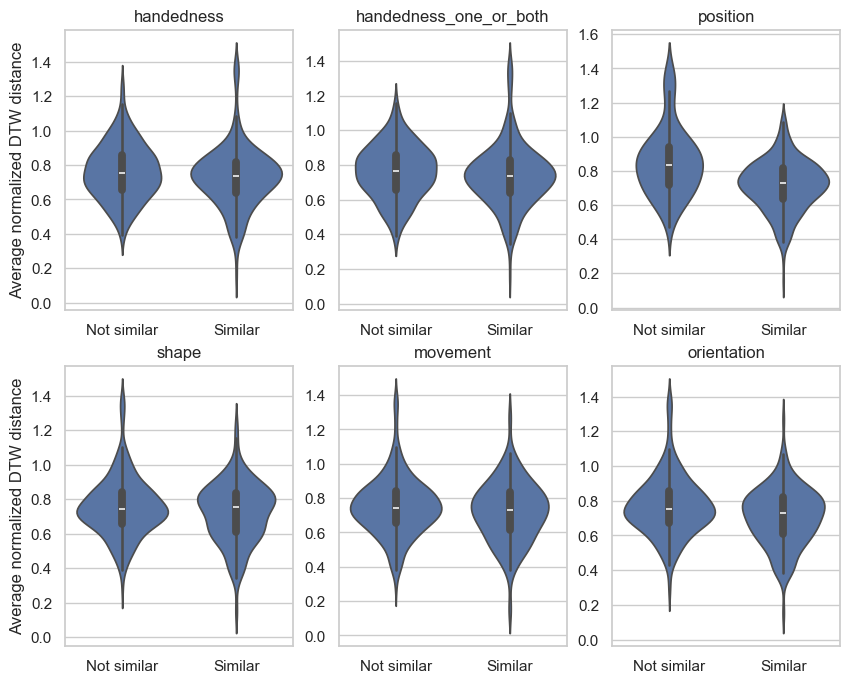

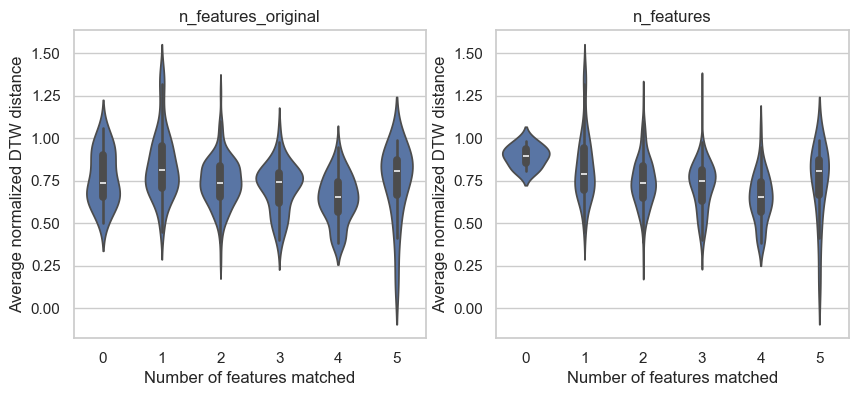

====================Duration difference====================


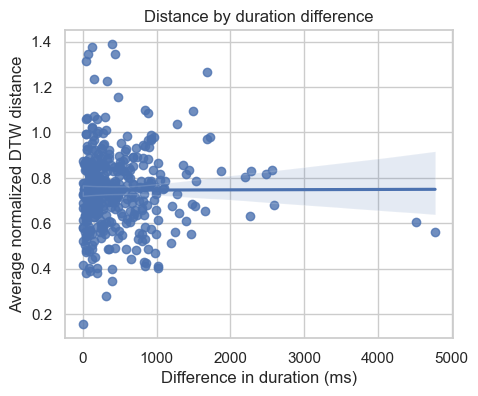

                                 OLS Regression Results                                
Dep. Variable:       average_distance   R-squared (uncentered):                   0.404
Model:                            OLS   Adj. R-squared (uncentered):              0.402
Method:                 Least Squares   F-statistic:                              274.4
Date:                Thu, 15 May 2025   Prob (F-statistic):                    1.98e-47
Time:                        00:05:07   Log-Likelihood:                         -362.46
No. Observations:                 406   AIC:                                      726.9
Df Residuals:                     405   BIC:                                      730.9
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                        coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------

In [22]:
image_folder = dtw_adjusted_folder + "images/"
### plot the average distance
df_dtw_adjusted = pd.read_csv(dtw_adjusted_folder + "dtw_distance.csv")
print("====================" + "Average distance" + "====================")
### plot the average distance for each feature
fig = plt.figure(figsize=(10, 8))
columns = 3
rows = 2
features = ["handedness", "handedness_one_or_both", "position", "shape", "movement", "orientation"]
plot_average_distance_feature(fig, columns, rows, features, df_dtw_adjusted)

### plot the average distance by the number of features matched
fig = plt.figure(figsize=(10, 4))
columns = 2
rows = 1
features = ["n_features_original", "n_features"]
plot_average_distance_nfeatures(fig, columns, rows, features, df_dtw_adjusted)

### plot the duration
print("====================" + "Duration difference" + "====================")
plot_average_distance_dur_diff(df_dtw_adjusted)

Unfortunately, the results haven't changed a lot. As such, we will use the time series with no duration adjustment from now on.

## DTW on modified time series
Another important thing to keep in mind is that speaker A and B are recorded from different angles.

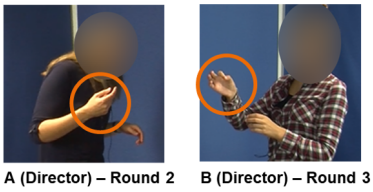

This makes the results of DTW unreliable because the same gestures produced by speaker A and speaker B "look different" and return different patterns for the mediapipe output. <br>
To be specific, we have the following issues due to the different camera angles:

1. For the right hand, the fingers are positioned right to the wrist for speaker A while they are positioned left to the wrist for speaker B (vice versa for the left hand).
1. Trajectory of identical movements will look different for each speaker. This applies to the x (horizontal) and z (depth) coordinates but less so to the y (vertical) coordinates.

To tackle this issue, we will perform the following preprocessing:

1. Use the relative position between the wrist and a joint for DTW. This is to minimize the chance of inflating the distance due to different position (values). For example, imagine that we have front-view recordings for two speakers, and they produced the identical movements but in different positions. In this case, the pattern in ts will be identical, but the values will be different. As DTW is senstive not only to the pattern in ts but also the value itself, identical movements in different positions will be "penalized" and have a larger distance. This "penalty" will be multiplied if we use multiple joints, as each joint will be penalized, and the penalty adds up. By using the relative positions for each joints, only the wrist will be penalized.
    - Maybe instead of using relative positions, we can use adjusted position for each finger by subtracting it with the *first* wrist position. This may improve the sensitivity to movements, as unlike the relative finger positions, it’s sensitive not only to the difference in the relative position to the wrist (important for hand shapes) but also for the pattern of each finger movement. <br>
    For example, if a speaker produces a gesture that has vertical movements without change in the hand shape, the relative position returns same values for all rows, while the adjusted finger coordinates will have the same pattern as the wrist.
1. Flip the horizontal (x) direction of the movements for speaker B (only for each compared gesture pair!!)
1. The segmentation of gesture strokes may not be perfectly accurate, and unreliable segmentation may significanly increase the distance. For details, please see [this paper](https://ieeexplore.ieee.org/document/7837974).

    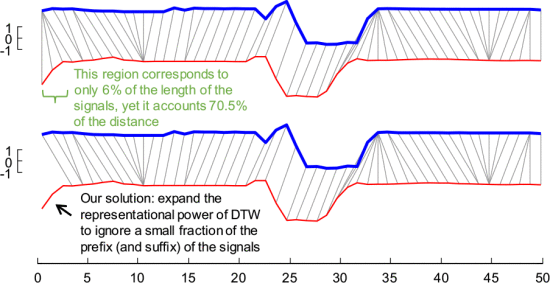

    Figure from Silva et al. (2016)

    To tackle this issue, we will perform asymmetric, loose beginning & end constraints DTW. <-- we tried out with simulated dataset if this improves the distance calculation, but we notcied that for short time series like ours it tends to only take the begining of query ts. As such, we will use more commonly used symmetric2 step pattern.

1. Only use x & y coordinates for DTW (decided to drop it instead of flipping them, because z tends to be more unreliable than x in mediapipe)
1. Only use the DTW distance for gesturing hands when calculating the average distance.

### Simulation of different approaches to extracting movements

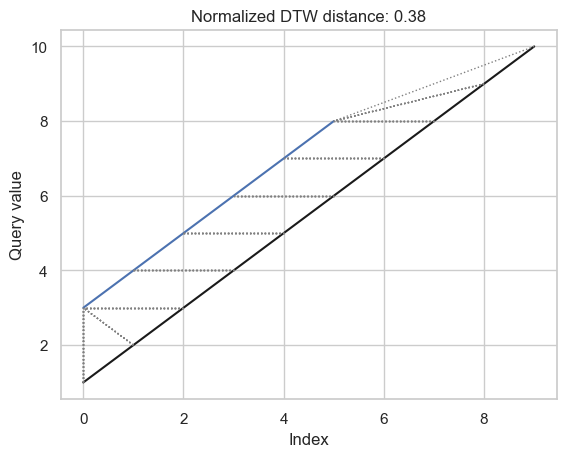

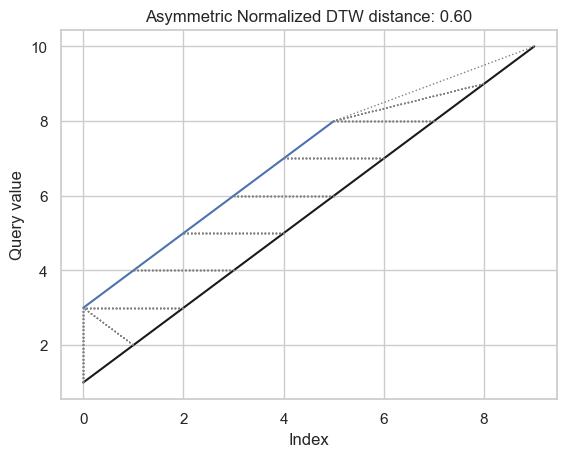

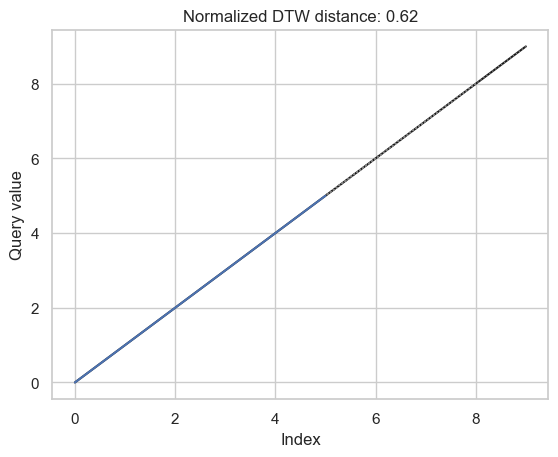

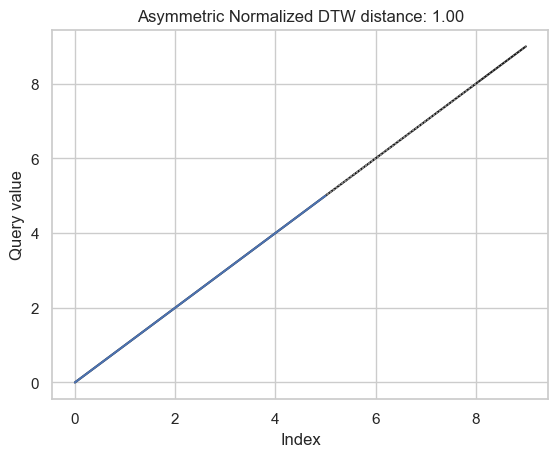

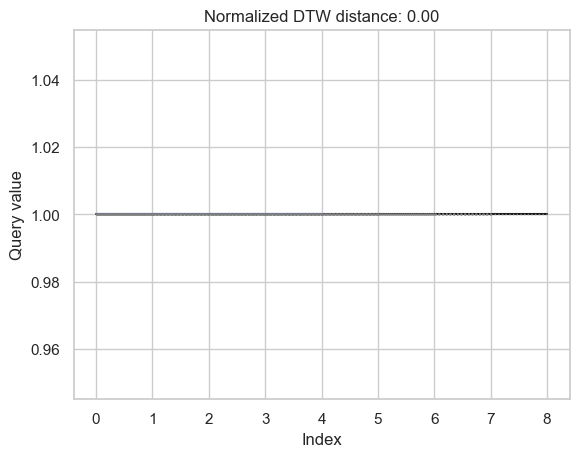

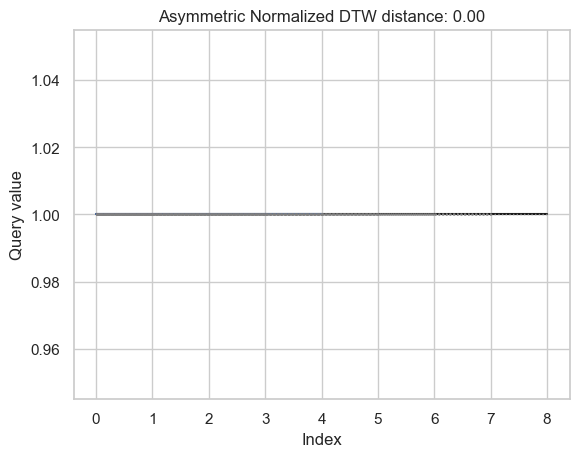

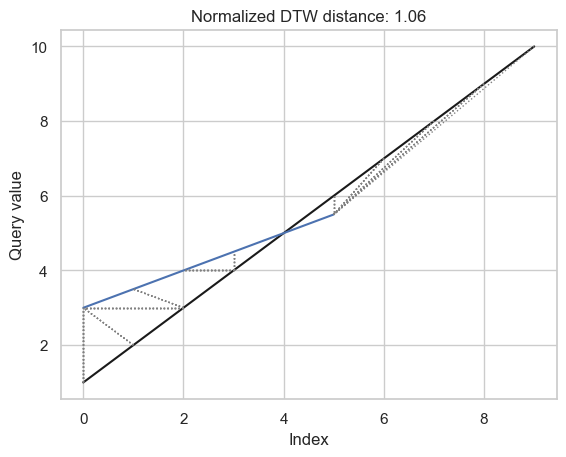

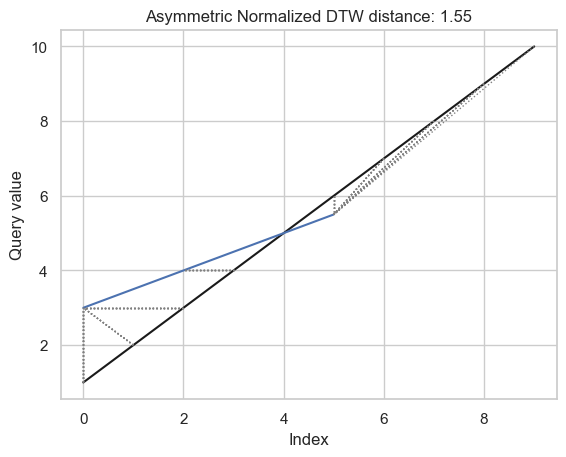

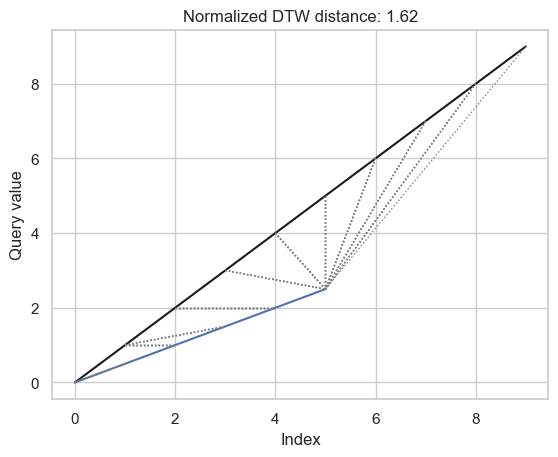

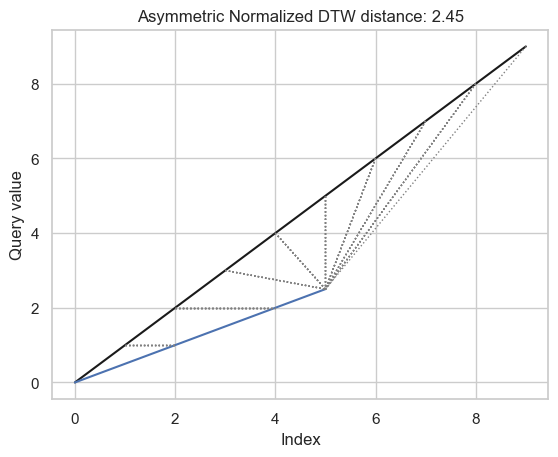

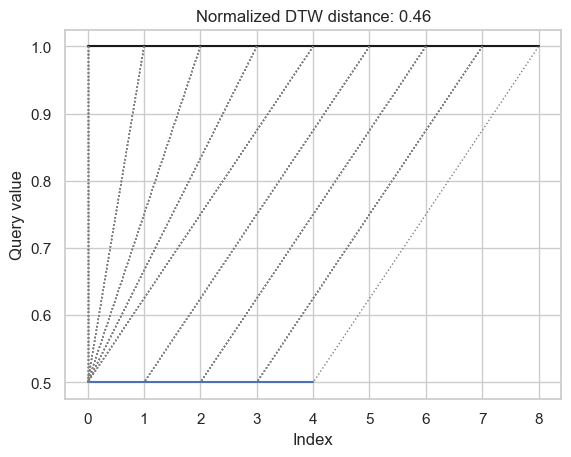

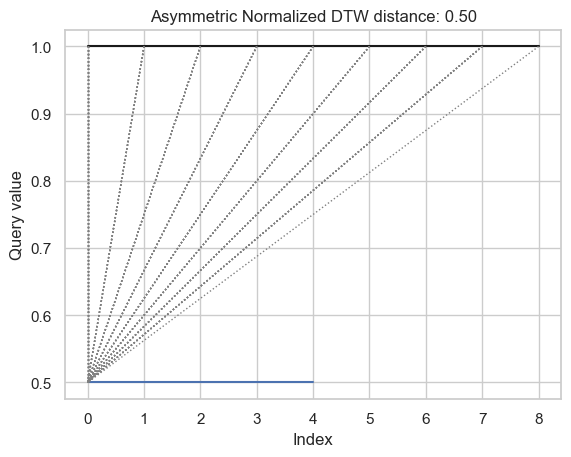

In [23]:
def compute_dtw_asymmetric(ts1, ts2):
    window_size = min(len(ts1), len(ts2)) // 10 # the window size is 10% of the length of the shortest timeseries
    if window_size < 3:
        window_size = 3 # the window size should be at least 3 frames

    res = dtw(ts1, ts2, 
              keep_internals = True,
              step_pattern = "asymmetric",
              open_begin = True, 
              open_end = True,
              window_args= {"window_type": "sakoechiba", "window_size": window_size})
    dis_normalized = res.normalizedDistance
    # add the result as the title of the plot
    dtwPlot(res, type="twoway")
    plt.title(f"Asymmetric Normalized DTW distance: {dis_normalized:.2f}")


ts1 = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
ts2 = np.array([3, 4, 5, 6, 7, 8])
ts3 = np.array([3, 3.5, 4, 4.5, 5, 5.5])

# normalize the initial location of the time series
ts1_norm = ts1 - ts1[0]
ts2_norm = ts2 - ts2[0]
ts3_norm = ts3 - ts3[0]

# take the difference between each frame
ts1_diff = np.diff(ts1)
ts2_diff = np.diff(ts2)
ts3_diff = np.diff(ts3)

# compute the distance using DTW
compute_dtw(ts1, ts2)
compute_dtw_asymmetric(ts1, ts2)
compute_dtw(ts1_norm, ts2_norm)
compute_dtw_asymmetric(ts1_norm, ts2_norm)
compute_dtw(ts1_diff, ts2_diff)
compute_dtw_asymmetric(ts1_diff, ts2_diff)

compute_dtw(ts1, ts3)
compute_dtw_asymmetric(ts1, ts3)
compute_dtw(ts1_norm, ts3_norm)
compute_dtw_asymmetric(ts1_norm, ts3_norm)
compute_dtw(ts1_diff, ts3_diff)
compute_dtw_asymmetric(ts1_diff, ts3_diff)

### Modify the time series (step 1 - 4)

In [ ]:
## keypoints
# identify which column indices in a dataframe correspond to which body parts
keypoint_thumb_right = ["X_RIGHT_THUMB_TIP", "Y_RIGHT_THUMB_TIP", "Z_RIGHT_THUMB_TIP"]
keypoint_thumb_left = ["X_LEFT_THUMB_TIP", "Y_LEFT_THUMB_TIP", "Z_LEFT_THUMB_TIP"]
keypoint_index_right =  ["X_RIGHT_INDEX_FINGER_TIP", "Y_RIGHT_INDEX_FINGER_TIP", "Z_RIGHT_INDEX_FINGER_TIP"]
keypoint_index_left = ["X_LEFT_INDEX_FINGER_TIP", "Y_LEFT_INDEX_FINGER_TIP", "Z_LEFT_INDEX_FINGER_TIP"]
keypoint_middle_right = ["X_RIGHT_MIDDLE_FINGER_TIP", "Y_RIGHT_MIDDLE_FINGER_TIP", "Z_RIGHT_MIDDLE_FINGER_TIP"]
keypoint_middle_left = ["X_LEFT_MIDDLE_FINGER_TIP", "Y_LEFT_MIDDLE_FINGER_TIP", "Z_LEFT_MIDDLE_FINGER_TIP"]
keypoint_ring_right = ["X_RIGHT_RING_FINGER_TIP", "Y_RIGHT_RING_FINGER_TIP", "Z_RIGHT_RING_FINGER_TIP"]
keypoint_ring_left = ["X_LEFT_RING_FINGER_TIP", "Y_LEFT_RING_FINGER_TIP", "Z_LEFT_RING_FINGER_TIP"]
keypoint_pinky_right =  ["X_RIGHT_PINKY_FINGER_TIP", "Y_RIGHT_PINKY_FINGER_TIP", "Z_RIGHT_PINKY_FINGER_TIP"]
keypoint_pinky_left = ["X_LEFT_PINKY_FINGER_TIP", "Y_LEFT_PINKY_FINGER_TIP", "Z_LEFT_PINKY_FINGER_TIP"]
keypoint_wrist_right = ["X_RIGHT_WRIST", "Y_RIGHT_WRIST", "Z_RIGHT_WRIST"]
keypoint_wrist_left = ["X_LEFT_WRIST", "Y_LEFT_WRIST", "Z_LEFT_WRIST"]

# make one 1 list with all keypoints
keypoints = list(itertools.chain(keypoint_thumb_right, keypoint_thumb_left, 
                                 keypoint_index_right, keypoint_index_left, 
                                 keypoint_middle_right, keypoint_middle_left, 
                                 keypoint_ring_right, keypoint_ring_left, 
                                 keypoint_pinky_right, keypoint_pinky_left, 
                                 keypoint_wrist_right, keypoint_wrist_left))


def calculate_relative_position(df, keypoints):
    relative_keypoints = [keypoint for keypoint in keypoints if "WRIST" not in keypoint]
    for keypoint in relative_keypoints:
        df[keypoint.lower() + "_relative"] = df[keypoint] - df["_".join(keypoint.split("_")[:2]) + "_WRIST"]
    return df

def calculate_adjusted_position(df, keypoints):
    '''
    This function calculates the adjusted position of each finger keypoint by subtracting the first position of each finger from the time series.
    The difference between this function and the calculate_relative_position function is that the calculate_relative_position function
    calculates the relative position of each finger keypoint with respect to the wrist position, while this function calculates the
    adjusted position of each finger keypoint with respect to the first position of the corrsponding finger.
    This means that all time series start at 0 for each finger keypoint, which solves the issue raised by potential segmentation difference at least for the "prefixes".
    '''
    adjusted_keypoints = [keypoint for keypoint in keypoints if "WRIST" not in keypoint]
    for keypoint in adjusted_keypoints:
        if not df[keypoint].empty:
            df[keypoint.lower() + "_adjusted"] = df[keypoint] - df[keypoint].iloc[0]
        else:
            print(f"Warning: {keypoint} series is empty.")
    return df

# def flip_relative_position(df):
#     relative_cols = [col for col in df.columns if "_relative" in col and "WRIST" not in col]
#     reverse_relative_cols = [col.split("_relative")[0] + "_reversed" for col in relative_cols]
#     df[reverse_relative_cols] = df[relative_cols] * -1
#     return df

def change_wrist_col_name(df):
    wrist_cols = [col for col in df.columns if "WRIST" in col]
    new_wrist_cols = [col.lower() for col in wrist_cols]
    df.rename(columns=dict(zip(wrist_cols, new_wrist_cols)), inplace=True)
    return df

def flip_direction(df):
    '''
    This function calculates the change in direction for each relative keypoint and flips the direction. 
    The mathmatical formula for flipping the direction is: x_current - 2*change = x_flipped
    To explain the formula, consider the following example:
        x_previous = 0, x_current = 2
    In this case, the change in direction is 2 (change = 2). The canonical formula for flipping the direction is: x_previous - change = x_flipped
    However, this requires the previous value, which requires to shift the row by 1. To avoid this, we can use the formula: x_current - 2*change = x_flipped
    So in this case, x_flipped = 2 - 2*2 = -2
    '''
    relative_cols = [col for col in df.columns if "_relative" in col and "x_" in col and "_z" not in col] # only flip the x direction
    wrist_cols = [col for col in df.columns if "wrist" in col and "x_" in col and "_z" not in col]
    flip_cols = relative_cols + wrist_cols
    change_relative_cols = [col.split("_relative")[0] + "_change" if "wrist" not in col else col + "_change" for col in flip_cols]

    # calculate the change in direction for each relative keypoint (e.g., the change for 0, 0, 2, 3 is NA(first row), 0, 1, 2)
    df[change_relative_cols] = df[flip_cols].diff() # calculate the change in direction; first row is NaN
    # flip the direction of the relative keypoints if the change is not NaN
    for col in flip_cols:
        if "wrist" in col:
            col_reversed = col + "_reversed"
            col_change = col + "_change"
        else:
            col_reversed = col.replace("_relative", "_reversed")
            col_change = col.replace("_relative", "_change")
        
        df[col_reversed] = np.where(df[col_change].isna(), df[col], df[col] - 2 * df[col_change])
    
    ### z-score the flipped relative keypoints
    df[flip_cols] = df[flip_cols].apply(zscore)

    return df

def center_wrist(df):
    wrist_cols = [col for col in df.columns if "wrist" in col if "_change" not in col]
    for col in wrist_cols:
        change_col = col + "_centered"
        df[change_col] = df[col] - df[col].mean()
    return df

def z_score_transform(df):
    relative_cols = [col for col in df.columns if "_relative" in col and "_change" not in col]
    wrist_cols = [col for col in df.columns if "wrist" in col if "_change" not in col]
    to_z_cols = relative_cols + wrist_cols
    for col in to_z_cols:
        col_na_filled = df[col].fillna(df[col].mean())
        df[col + "_z"] = zscore(col_na_filled)
    return df

def calculate_euclidian_distance(df):
    '''
    This function calculates the euclidian distance between the finger tip and the wrist.
    We use the relative columns because they are calculated with respect to the wrist position (e.g., x_left_index_tip - x_left_wrist).
    '''
    # get the base name of the relative columns (e.g., left_thumb)
    relative_cols = [col[2:] for col in df.columns if "_relative" in col and "wrist" not in col and col.startswith("x_")]
    for col in relative_cols:
        euclidian_col = col.split("_relative")[0] + "_euclidian"
        df[euclidian_col] = np.sqrt(np.square(df["x_" + col]) + np.square(df["y_" + col]) + np.square(df["z_" + col]))
        
    return df

def load_in_event(time_original, adata, col, speaker, i, adj_dur):
    output = np.full(len(time_original), np.nan, dtype=object)  # Initialize output array with NaN values
    speaker_1 = adata.loc[i, 'speaker_1']
    speaker_2 = adata.loc[i, 'speaker_2']

    if adj_dur == True:
        A_begin_col = 'A_begin_msec_adj'
        A_end_col = 'A_end_msec_adj'
        B_begin_col = 'B_begin_msec_adj'
        B_end_col = 'B_end_msec_adj'
    else:
        A_begin_col = 'A_begin_msec'
        A_end_col = 'A_end_msec'
        B_begin_col = 'B_begin_msec'
        B_end_col = 'B_end_msec'

    if speaker == 'A':
        output[(time_original >= adata.loc[i, A_begin_col]) & (time_original <= adata.loc[i, A_end_col])] = adata.iloc[i, adata.columns.get_loc(col)]
    elif speaker == 'B':
        output[(time_original >= adata.loc[i, B_begin_col]) & (time_original <= adata.loc[i, B_end_col])] = adata.iloc[i, adata.columns.get_loc(col)]
    
    return output

def export_merge_annot(MT_files, anno, ts_annot_folder, reverse=False, adj_dur=False):
    # merged_data_list = []
    merged_data = pd.DataFrame()  # Initialize an empty DataFrame

    n_comparisons = len(anno) #this should be 419
    print("Number of comparisons: " + str(n_comparisons))

    skip_count = 0
    skip_files = []

    for mt_file in tqdm(MT_files):
        fname = os.path.basename(mt_file).split('_ns')[0]
        # check if the processed file already exists
        if glob.glob(ts_annot_folder + fname + "*.csv"):
            skip_count += 1
            skip_files.append(fname)
            continue # Skip the file if it already exists. 

        ### get the speaker and pair number
        speaker = fname.split('pp')[1] # Extract the speaker from the file name
        pair_n = int(fname.split('pair')[1].split('_')[0]) # Extract the pair number from the file name and convert it to an integer
        if pair_n not in anno['pairnr'].values:
            # print("Pair number " + str(pair_n) + " not found in the annotation file.")
            continue
        
        ### load in the time series data
        mdata = pd.read_csv(mt_file)
        adata = anno[anno['pairnr'] == pair_n].reset_index(drop=True)

        # mdata = flip_sign_for_y(mdata)
        mdata = calculate_relative_position(mdata, keypoints)
        change_wrist_col_name(mdata)
        mdata = calculate_euclidian_distance(mdata)
        # mdata = center_wrist(mdata)
        # mdata = z_score_transform(mdata)
        ### calculate the change in x,y,z axis for each relative keypoint
        wrist_movement_cols = [col for col in mdata.columns if "wrist" in col]
        # movement_cols = [col for col in mdata.columns if "_relative" in col or "wrist" in col]
        for col in wrist_movement_cols:
            mdata[col + "_movement"] = mdata[col].diff()
            # fill empty values with 0
            mdata[col + "_movement"] = mdata[col + "_movement"].fillna(0)
        merged_data = mdata.copy()

        cols = ["comparison_id"]
        for i in range(len(adata)):
            comparison_id = adata.loc[i, 'comparison_id']
            hands_dtw = adata.loc[i, 'hands_dtw']
            # Initialize a pandas dataframe and a dictionary to hold new columns (this approach is faster than appending to a DataFrame in a loop)
            new_cols_df = pd.DataFrame()
            new_cols = {}
            # Add the new column to the dictionary
            new_cols['File'] = [fname] * len(merged_data)
            new_cols['Speaker'] = [speaker] * len(merged_data)

            # Apply the function to each column and store the result in the dictionary
            for col in cols:
                new_cols[col] = load_in_event(merged_data['time'], adata, col, speaker, i, adj_dur)

            # Create a new DataFrame from the dictionary
            new_cols_df = pd.DataFrame(new_cols)
            # Concatenate the original DataFrame with the new DataFrame
            final_merged_data = pd.concat([merged_data, new_cols_df], axis=1)
            final_merged_data = final_merged_data[final_merged_data['comparison_id'].notna()]
            final_merged_data = calculate_adjusted_position(final_merged_data, keypoints)
            final_merged_data = z_score_transform(final_merged_data)
            # if the speaker is ppB, flip the direction of the relative keypoints
            if "ppB" in fname and reverse == True:
                final_merged_data = flip_direction(final_merged_data)
            
            # drop unnecesary columns and export the merged data to a csv file
            cols_to_drop = [col for col in final_merged_data.columns if "X" in col or "Y" in col or "Z" in col]
            final_merged_data.drop(columns=cols_to_drop, inplace=True)

            final_merged_data.to_csv(ts_annot_folder + fname + "_" + str(comparison_id) + "_" + hands_dtw + ".csv", index=False)
            # merged_data_list.append(merged_data)
        
    # # Concatenate all DataFrames in the list into one DataFrame
    # final_merged_data = pd.concat(merged_data_list, ignore_index=True)

#### Export the modified time series

In [25]:
ts_annot_modified_reversed_folder = ts_annot_modified_folder + "reversed/"
MT_files = glob.glob(norm_smooth_folder + "*.csv")
anno = pd.read_csv(anno_path + "gesture_form_similarity_coding_processed.csv")

export_merge_annot(MT_files, anno, ts_annot_modified_folder, adj_dur=True)
# export_merge_annot(MT_files, anno, ts_annot_modified_reversed_folder, reverse=True)

Number of comparisons: 419


100%|██████████| 38/38 [01:42<00:00,  2.68s/it]


### Run DTW (step 4 - 5)
#### Define function

In [26]:
# identify which column indices in a dataframe correspond to which body parts
keypoint_thumb_right = ["x_right_thumb_tip_relative", "y_right_thumb_tip_relative"]
keypoint_thumb_left = ["x_left_thumb_tip_relative", "y_left_thumb_tip_relative"]
keypoint_index_right =  ["x_right_index_finger_tip_relative", "y_right_index_finger_tip_relative"]
keypoint_index_left = ["x_left_index_finger_tip_relative", "y_left_index_finger_tip_relative"]
keypoint_middle_right = ["x_right_middle_finger_tip_relative", "y_right_middle_finger_tip_relative"]
keypoint_middle_left = ["x_left_middle_finger_tip_relative", "y_left_middle_finger_tip_relative"]
keypoint_ring_right = ["x_right_ring_finger_tip_relative", "y_right_ring_finger_tip_relative"]
keypoint_ring_left = ["x_left_ring_finger_tip_relative", "y_left_ring_finger_tip_relative"]
keypoint_pinky_right =  ["x_right_pinky_finger_tip_relative", "y_right_pinky_finger_tip_relative"]
keypoint_pinky_left = ["x_left_pinky_finger_tip_relative", "y_left_pinky_finger_tip_relative"]
keypoint_wrist_right = ["x_right_wrist", "y_right_wrist"] # the y is added to the wrist keypoint because the wrist keypoint is present in both body and hands time series
keypoint_wrist_left = ["x_left_wrist", "y_left_wrist"]
keypoint_wrist_right_movement = ["x_right_wrist_movement", "y_right_wrist_movement"]
keypoint_wrist_left_movement = ["x_left_wrist_movement", "y_left_wrist_movement"]

# make one 1 list with all keypoints
keypoints = list(itertools.chain(keypoint_thumb_right, keypoint_thumb_left, 
                                 keypoint_index_right, keypoint_index_left, 
                                 keypoint_middle_right, keypoint_middle_left, 
                                 keypoint_ring_right, keypoint_ring_left, 
                                 keypoint_pinky_right, keypoint_pinky_left, 
                                 keypoint_wrist_right, keypoint_wrist_left,
                                 keypoint_wrist_right_movement, keypoint_wrist_left_movement))

# reversed keypoints (only the x direction is reversed)
keypoint_thumb_right_reversed = ["x_right_thumb_tip_reversed", "y_right_thumb_tip_relative"]
keypoint_thumb_left_reversed = ["x_left_thumb_tip_reversed", "y_left_thumb_tip_relative"]
keypoint_index_right_reversed =  ["x_right_index_finger_tip_reversed", "y_right_index_finger_tip_relative"]
keypoint_index_left_reversed = ["x_left_index_finger_tip_reversed", "y_left_index_finger_tip_relative"]
keypoint_middle_right_reversed = ["x_right_middle_finger_tip_reversed", "y_right_middle_finger_tip_relative"]
keypoint_middle_left_reversed = ["x_left_middle_finger_tip_reversed", "y_left_middle_finger_tip_relative"]
keypoint_ring_right_reversed = ["x_right_ring_finger_tip_reversed", "y_right_ring_finger_tip_relative"]
keypoint_ring_left_reversed = ["x_left_ring_finger_tip_reversed", "y_left_ring_finger_tip_relative"]
keypoint_pinky_right_reversed =  ["x_right_pinky_finger_tip_reversed", "y_right_pinky_finger_tip_relative"]
keypoint_pinky_left_reversed = ["x_left_pinky_finger_tip_reversed", "y_left_pinky_finger_tip_relative"]
keypoint_wrist_right_reversed = ["x_right_wrist_reversed", "y_right_wrist"]
keypoint_wrist_left_reversed = ["x_left_wrist_reversed", "y_left_wrist"]

keypoints_reversed = list(itertools.chain(keypoint_thumb_right_reversed, keypoint_thumb_left_reversed,
                                            keypoint_index_right_reversed, keypoint_index_left_reversed,
                                            keypoint_middle_right_reversed, keypoint_middle_left_reversed,
                                            keypoint_ring_right_reversed, keypoint_ring_left_reversed,
                                            keypoint_pinky_right_reversed, keypoint_pinky_left_reversed,
                                            keypoint_wrist_right_reversed, keypoint_wrist_left_reversed))

# keypoints for all coordinates (x, y, z)
keypoint_thumb_right_xyz = ["x_right_thumb_tip_relative", "y_right_thumb_tip_relative", "z_right_thumb_tip_relative"]
keypoint_thumb_left_xyz = ["x_left_thumb_tip_relative", "y_left_thumb_tip_relative", "z_left_thumb_tip_relative"]
keypoint_index_right_xyz =  ["x_right_index_finger_tip_relative", "y_right_index_finger_tip_relative", "z_right_index_finger_tip_relative"]
keypoint_index_left_xyz = ["x_left_index_finger_tip_relative", "y_left_index_finger_tip_relative", "z_left_index_finger_tip_relative"]
keypoint_middle_right_xyz = ["x_right_middle_finger_tip_relative", "y_right_middle_finger_tip_relative", "z_right_middle_finger_tip_relative"]
keypoint_middle_left_xyz = ["x_left_middle_finger_tip_relative", "y_left_middle_finger_tip_relative", "z_left_middle_finger_tip_relative"]
keypoint_ring_right_xyz = ["x_right_ring_finger_tip_relative", "y_right_ring_finger_tip_relative", "z_right_ring_finger_tip_relative"]
keypoint_ring_left_xyz = ["x_left_ring_finger_tip_relative", "y_left_ring_finger_tip_relative", "z_left_ring_finger_tip_relative"]
keypoint_pinky_right_xyz =  ["x_right_pinky_finger_tip_relative", "y_right_pinky_finger_tip_relative", "z_right_pinky_finger_tip_relative"]
keypoint_pinky_left_xyz = ["x_left_pinky_finger_tip_relative", "y_left_pinky_finger_tip_relative", "z_left_pinky_finger_tip_relative"]
keypoint_wrist_right_xyz = ["x_right_wrist", "y_right_wrist", "z_right_wrist"]
keypoint_wrist_left_xyz = ["x_left_wrist", "y_left_wrist", "z_left_wrist"]
keypoint_wrist_right_xyz_movement = ["x_right_wrist_movement", "y_right_wrist_movement", "z_right_wrist_movement"]
keypoint_wrist_left_xyz_movement = ["x_left_wrist_movement", "y_left_wrist_movement", "z_left_wrist_movement"]

keypoints_xyz = list(itertools.chain(keypoint_thumb_right_xyz, keypoint_thumb_left_xyz, 
                                     keypoint_index_right_xyz, keypoint_index_left_xyz, 
                                     keypoint_middle_right_xyz, keypoint_middle_left_xyz, 
                                     keypoint_ring_right_xyz, keypoint_ring_left_xyz, 
                                     keypoint_pinky_right_xyz, keypoint_pinky_left_xyz, 
                                     keypoint_wrist_right_xyz, keypoint_wrist_left_xyz,
                                     keypoint_wrist_right_xyz_movement, keypoint_wrist_left_xyz_movement))
keypoints_xyz_left = list(itertools.chain(keypoint_thumb_left_xyz, 
                                     keypoint_index_left_xyz, 
                                     keypoint_middle_left_xyz, 
                                     keypoint_ring_left_xyz, 
                                     keypoint_pinky_left_xyz, 
                                     keypoint_wrist_left_xyz,
                                     keypoint_wrist_left_xyz_movement))
keypoints_xyz_right = list(itertools.chain(keypoint_thumb_right_xyz,
                                        keypoint_index_right_xyz, 
                                        keypoint_middle_right_xyz, 
                                        keypoint_ring_right_xyz, 
                                        keypoint_pinky_right_xyz, 
                                        keypoint_wrist_right_xyz,
                                        keypoint_wrist_right_xyz_movement))

keypoint_thumb_right_adjusted = ["x_right_thumb_tip_adjusted", "y_right_thumb_tip_adjusted"]
keypoint_thumb_left_adjusted = ["x_left_thumb_tip_adjusted", "y_left_thumb_tip_adjusted"]
keypoint_index_right_adjusted =  ["x_right_index_finger_tip_adjusted", "y_right_index_finger_tip_adjusted"]
keypoint_index_left_adjusted = ["x_left_index_finger_tip_adjusted", "y_left_index_finger_tip_adjusted"]
keypoint_middle_right_adjusted = ["x_right_middle_finger_tip_adjusted", "y_right_middle_finger_tip_adjusted"]
keypoint_middle_left_adjusted = ["x_left_middle_finger_tip_adjusted", "y_left_middle_finger_tip_adjusted"]
keypoint_ring_right_adjusted = ["x_right_ring_finger_tip_adjusted", "y_right_ring_finger_tip_adjusted"]
keypoint_ring_left_adjusted = ["x_left_ring_finger_tip_adjusted", "y_left_ring_finger_tip_adjusted"]
keypoint_pinky_right_adjusted =  ["x_right_pinky_finger_tip_adjusted", "y_right_pinky_finger_tip_adjusted"]
keypoint_pinky_left_adjusted = ["x_left_pinky_finger_tip_adjusted", "y_left_pinky_finger_tip_adjusted"]

keypoints_adjusted = list(itertools.chain(keypoint_thumb_right_adjusted, keypoint_thumb_left_adjusted,
                                            keypoint_index_right_adjusted, keypoint_index_left_adjusted,
                                            keypoint_middle_right_adjusted, keypoint_middle_left_adjusted,
                                            keypoint_ring_right_adjusted, keypoint_ring_left_adjusted,
                                            keypoint_pinky_right_adjusted, keypoint_pinky_left_adjusted))

keypoint_thumb_right_z = ["x_right_thumb_tip_relative_z", "y_right_thumb_tip_relative_z"]
keypoint_thumb_left_z = ["x_left_thumb_tip_relative_z", "y_left_thumb_tip_relative_z"]
keypoint_index_right_z =  ["x_right_index_finger_tip_relative_z", "y_right_index_finger_tip_relative_z"]
keypoint_index_left_z = ["x_left_index_finger_tip_relative_z", "y_left_index_finger_tip_relative_z"]
keypoint_middle_right_z = ["x_right_middle_finger_tip_relative_z", "y_right_middle_finger_tip_relative_z"]
keypoint_middle_left_z = ["x_left_middle_finger_tip_relative_z", "y_left_middle_finger_tip_relative_z"]
keypoint_ring_right_z = ["x_right_ring_finger_tip_relative_z", "y_right_ring_finger_tip_relative_z"]
keypoint_ring_left_z = ["x_left_ring_finger_tip_relative_z", "y_left_ring_finger_tip_relative_z"]
keypoint_pinky_right_z =  ["x_right_pinky_finger_tip_relative_z", "y_right_pinky_finger_tip_relative_z"]
keypoint_pinky_left_z = ["x_left_pinky_finger_tip_relative_z", "y_left_pinky_finger_tip_relative_z"]
keypoint_wrist_right_z = ["x_right_wrist_z", "y_right_wrist_z"]
keypoint_wrist_left_z = ["x_left_wrist_z", "y_left_wrist_z"]

keypoints_z = list(itertools.chain(keypoint_thumb_right_z, keypoint_thumb_left_z,
                                        keypoint_index_right_z, keypoint_index_left_z,
                                        keypoint_middle_right_z, keypoint_middle_left_z,
                                        keypoint_ring_right_z, keypoint_ring_left_z,
                                        keypoint_pinky_right_z, keypoint_pinky_left_z,
                                        keypoint_wrist_right_z, keypoint_wrist_left_z))

keypoint_thumb_right_xyz_z = ["x_right_thumb_tip_relative_z", "y_right_thumb_tip_relative_z", "z_right_thumb_tip_relative_z"]
keypoint_thumb_left_xyz_z = ["x_left_thumb_tip_relative_z", "y_left_thumb_tip_relative_z", "z_left_thumb_tip_relative_z"]
keypoint_index_right_xyz_z =  ["x_right_index_finger_tip_relative_z", "y_right_index_finger_tip_relative_z", "z_right_index_finger_tip_relative_z"]
keypoint_index_left_xyz_z = ["x_left_index_finger_tip_relative_z", "y_left_index_finger_tip_relative_z", "z_left_index_finger_tip_relative_z"]
keypoint_middle_right_xyz_z = ["x_right_middle_finger_tip_relative_z", "y_right_middle_finger_tip_relative_z", "z_right_middle_finger_tip_relative_z"]
keypoint_middle_left_xyz_z = ["x_left_middle_finger_tip_relative_z", "y_left_middle_finger_tip_relative_z", "z_left_middle_finger_tip_relative_z"]
keypoint_ring_right_xyz_z = ["x_right_ring_finger_tip_relative_z", "y_right_ring_finger_tip_relative_z", "z_right_ring_finger_tip_relative_z"]
keypoint_ring_left_xyz_z = ["x_left_ring_finger_tip_relative_z", "y_left_ring_finger_tip_relative_z", "z_left_ring_finger_tip_relative_z"]
keypoint_pinky_right_xyz_z =  ["x_right_pinky_finger_tip_relative_z", "y_right_pinky_finger_tip_relative_z", "z_right_pinky_finger_tip_relative_z"]
keypoint_pinky_left_xyz_z = ["x_left_pinky_finger_tip_relative_z", "y_left_pinky_finger_tip_relative_z", "z_left_pinky_finger_tip_relative_z"]
keypoint_wrist_right_xyz_z = ["x_right_wrist_z", "y_right_wrist_z", "z_right_wrist_z"]
keypoint_wrist_left_xyz_z = ["x_left_wrist_z", "y_left_wrist_z", "z_left_wrist_z"]

keypoints_xyz_z = list(itertools.chain(keypoint_thumb_right_xyz_z, keypoint_thumb_left_xyz_z,
                                     keypoint_index_right_xyz_z, keypoint_index_left_xyz_z, 
                                     keypoint_middle_right_xyz_z, keypoint_middle_left_xyz_z, 
                                     keypoint_ring_right_xyz_z, keypoint_ring_left_xyz_z, 
                                     keypoint_pinky_right_xyz_z, keypoint_pinky_left_xyz_z, 
                                     keypoint_wrist_right_xyz_z, keypoint_wrist_left_xyz_z))

keypoint_thumb_left_euclidian = "left_thumb_tip_euclidian"
keypoint_index_left_euclidian = "left_index_finger_tip_euclidian"
keypoint_middle_left_euclidian = "left_middle_finger_tip_euclidian"
keypoint_ring_left_euclidian = "left_ring_finger_tip_euclidian"
keypoint_pinky_left_euclidian = "left_pinky_finger_tip_euclidian"
keypoint_thumb_right_euclidian = "right_thumb_tip_euclidian"
keypoint_index_right_euclidian = "right_index_finger_tip_euclidian"
keypoint_middle_right_euclidian = "right_middle_finger_tip_euclidian"
keypoint_ring_right_euclidian = "right_ring_finger_tip_euclidian"
keypoint_pinky_right_euclidian = "right_pinky_finger_tip_euclidian"

keypoints_euclidian = [keypoint_thumb_left_euclidian, keypoint_index_left_euclidian, keypoint_middle_left_euclidian, keypoint_ring_left_euclidian, keypoint_pinky_left_euclidian,
                        keypoint_thumb_right_euclidian, keypoint_index_right_euclidian, keypoint_middle_right_euclidian, keypoint_ring_right_euclidian, keypoint_pinky_right_euclidian]


def detect_hands(MT1, MT2, hands_dtw):
    ### detect gesturing hands (unless the handedness_dtw is set to "both")
    # if the range of values for index finger tip is higher for the left hand, the left hand is gesturing
    if hands_dtw == "both":
        detected_hands = "both"
    else:
        ### test if the variance of the left hand is higher than the right hand
        A_left, A_right = MT1[keypoint_index_left], MT1[keypoint_index_right]
        B_left, B_right = MT2[keypoint_index_left], MT2[keypoint_index_right]
        # Calculate the standard deviation
        A_left_sd, A_right_sd = np.mean(np.std(A_left, ddof=1, axis=0)), np.mean(np.std(A_right, ddof=1, axis=0))
        B_left_sd, B_right_sd = np.mean(np.std(B_left, ddof=1, axis=0)), np.mean(np.std(B_right, ddof=1, axis=0))
        # compute p-value using Levene's test to see if the variances are significantly different
        A_stat, A_p_values = levene(A_left, A_right)
        B_stat, B_p_values = levene(B_left, B_right)
        alpha = 0.05
        # check the significance of the p-values
        A_significance_index = np.where(A_p_values < alpha)[0]
        B_significance_index = np.where(B_p_values < alpha)[0]
        # update the probabilities
        A_left_prob = 0.5 if len(A_significance_index) > 0 and A_left_sd > A_right_sd else 0
        A_right_prob = 0.5 if len(A_significance_index) > 0 and A_right_sd > A_left_sd else 0
        B_left_prob = 0.5 if len(B_significance_index) > 0 and B_left_sd > B_right_sd else 0
        B_right_prob = 0.5 if len(B_significance_index) > 0 and B_right_sd > B_left_sd else 0

        ### check if one hand is significantly higher than the other
        A_t_value, A_p_value = ttest_ind(A_left.iloc[:, 1], A_right.iloc[:, 1]) # test the y coordinate
        B_t_value, B_p_value = ttest_ind(B_left.iloc[:, 1], B_right.iloc[:, 1])
        # update the probabilities
        A_left_prob += 0.5 if A_p_value < alpha and A_t_value > 0 else 0 # positive t value means that the left hand is higher
        A_right_prob += 0.5 if A_p_value < alpha and B_t_value < 0 else 0 # negative t value means that the right hand is higher
        B_left_prob += 0.5 if B_p_value < alpha and B_t_value > 0 else 0
        B_right_prob += 0.5 if B_p_value < alpha and B_t_value < 0 else 0
        
        # detect the hands
        if A_left_prob == 1:
            detected_hands_A = "left"
        elif A_right_prob == 1:
            detected_hands_A = "right"
        else:
            detected_hands_A = None

        if B_left_prob == 1:
            detected_hands_B = "left"
        elif B_right_prob == 1:
            detected_hands_B = "right"
        else: 
            detected_hands_B = None

        if detected_hands_A == None or detected_hands_B == None:
            detected_hands = None
        elif detected_hands_A == detected_hands_B:
            detected_hands = detected_hands_A
        else:
            detected_hands = f"{detected_hands_A}_{detected_hands_B}"

    return detected_hands

#make a function that takes in two timeseries and produces a normalized dtw distance
def dtw_distance_normalized(ts1, ts2, 
                            pair=None, comparison_id=None, keypoint=None): # these are the arguments that are only needed for the plot
    ts1 = np.array(ts1)
    ts2 = np.array(ts2)

    #dtw init
    window_size = min(len(ts1), len(ts2)) // 10 # the window size is 10% of the length of the shortest timeseries
    if window_size < 3:
        window_size = 3 # the window size should be at least 3 frames

    # slope_descriptor = SlopeDescriptor(slope_window=window_size)
    # paa_descriptor = PAADescriptor(piecewise_aggregation_window=5)
    # compound_descriptor = CompoundDescriptor([slope_descriptor, paa_descriptor],descriptors_weights=[5., 1.])

    #now calculate a multidimesnional (dependent) dtw distance using dtwParallel Multivariate = true, type dtw = dependent, distance is euclidean, compare the two timeseries only locally (sakoe_chiba)
    res = dtw(ts1, ts2, 
              step_pattern = "symmetric2",
              keep_internals = True, 
              window_args= {"window_type": "sakoechiba", "window_size": window_size})
    normalized_distance = res.normalizedDistance

    ### visualize DTW alignment
    # if pair != None and comparison_id != None and keypoint != None: # make a plot only all the arguments are provided
    #     pair_folder = f"{dtw_modified_folder}/plots/{pair}/"
    #     if not os.path.exists(pair_folder):
    #         os.makedirs(pair_folder)
    #     plot_filename = pair_folder + f"{pair}_{comparison_id}_{keypoint}_{round(normalized_distance, 2)}.png"
    #     plot = dtwPlot(res, plot_type="twoway")
    #     plot.savefig(plot_filename)
    
    return normalized_distance

def dtw_distance_normalized_z(ts1, ts2):
    ### z-score the combined time series
    ts1_len, ts2_len = len(ts1), len(ts2)
    ts_id = np.array([1] * ts1_len + [2] * ts2_len)
    ts_combined = pd.concat([ts1, ts2], ignore_index=True)

    # z-score the combined time series
    ts_combined = zscore(ts_combined.loc[:, ts_combined.columns != "ts_id"])
    ts_combined["ts_id"] = ts_id
    ts1 = ts_combined[ts_combined["ts_id"] == 1].drop(columns="ts_id")
    ts2 = ts_combined[ts_combined["ts_id"] == 2].drop(columns="ts_id")

    # convert the time series to numpy arrays
    ts1 = np.array(ts1)
    ts2 = np.array(ts2)

    return dtw_distance_normalized(ts1, ts2)

def enclidean_distance(ts1, ts2):
    ts1 = np.array(ts1)
    ts2 = np.array(ts2)
    mean1 = np.mean(ts1, axis=0)
    mean2 = np.mean(ts2, axis=0)
    return distance.euclidean(mean1, mean2)



# make a dependent dtw such that each keypoint dtw distance is added up and divided by the number of keypoints
def dtw_distance_dependent(MT1, MT2, distance_array, hands_dtw, pair, comparison_id):
    ### calculate the dtw distance for each keypoint
    # distance
    dis_left_thumb = dtw_distance_normalized(MT1[keypoint_thumb_left], MT2[keypoint_thumb_left], pair, comparison_id, "left_thumb")
    dis_left_index = dtw_distance_normalized(MT1[keypoint_index_left], MT2[keypoint_index_left], pair, comparison_id, "left_index")
    dis_left_middle = dtw_distance_normalized(MT1[keypoint_middle_left], MT2[keypoint_middle_left], pair, comparison_id, "left_middle")
    dis_left_ring = dtw_distance_normalized(MT1[keypoint_ring_left], MT2[keypoint_ring_left], pair, comparison_id, "left_ring")
    dis_left_pinky = dtw_distance_normalized(MT1[keypoint_pinky_left], MT2[keypoint_pinky_left], pair, comparison_id, "left_pinky")
    dis_left_wrist = dtw_distance_normalized(MT1[keypoint_wrist_left], MT2[keypoint_wrist_left], pair, comparison_id, "left_wrist")
    dis_left_movement = dtw_distance_normalized(MT1[keypoint_wrist_left_movement], MT2[keypoint_wrist_left_movement], pair, comparison_id, "left_wrist_movement")
    dis_left_position = enclidean_distance(MT1[keypoint_wrist_left], MT2[keypoint_wrist_left])
    dis_right_thumb = dtw_distance_normalized(MT1[keypoint_thumb_right], MT2[keypoint_thumb_right], pair, comparison_id, "right_thumb")
    dis_right_index = dtw_distance_normalized(MT1[keypoint_index_right], MT2[keypoint_index_right], pair, comparison_id, "right_index")
    dis_right_middle = dtw_distance_normalized(MT1[keypoint_middle_right], MT2[keypoint_middle_right], pair, comparison_id, "right_middle")
    dis_right_ring = dtw_distance_normalized(MT1[keypoint_ring_right], MT2[keypoint_ring_right], pair, comparison_id, "right_ring")
    dis_right_pinky = dtw_distance_normalized(MT1[keypoint_pinky_right], MT2[keypoint_pinky_right], pair, comparison_id, "right_pinky")
    dis_right_wrist = dtw_distance_normalized(MT1[keypoint_wrist_right], MT2[keypoint_wrist_right], pair, comparison_id, "right_wrist")
    dis_right_movement = dtw_distance_normalized(MT1[keypoint_wrist_right_movement], MT2[keypoint_wrist_right_movement], pair, comparison_id, "right_wrist_movement")
    dis_right_position = enclidean_distance(MT1[keypoint_wrist_right], MT2[keypoint_wrist_right])
    # # distance_z (z-scored for each gesture)
    # dis_left_thumb_z = dtw_distance_normalized(MT1[keypoint_thumb_left_z], MT2[keypoint_thumb_left_z])
    # dis_left_index_z = dtw_distance_normalized(MT1[keypoint_index_left_z], MT2[keypoint_index_left_z])
    # dis_left_middle_z = dtw_distance_normalized(MT1[keypoint_middle_left_z], MT2[keypoint_middle_left_z])
    # dis_left_ring_z = dtw_distance_normalized(MT1[keypoint_ring_left_z], MT2[keypoint_ring_left_z])
    # dis_left_pinky_z = dtw_distance_normalized(MT1[keypoint_pinky_left_z], MT2[keypoint_pinky_left_z])
    # dis_left_wrist_z = dtw_distance_normalized(MT1[keypoint_wrist_left_z], MT2[keypoint_wrist_left_z])
    # dis_right_thumb_z = dtw_distance_normalized(MT1[keypoint_thumb_right_z], MT2[keypoint_thumb_right_z])
    # dis_right_index_z = dtw_distance_normalized(MT1[keypoint_index_right_z], MT2[keypoint_index_right_z])
    # dis_right_middle_z = dtw_distance_normalized(MT1[keypoint_middle_right_z], MT2[keypoint_middle_right_z])
    # dis_right_ring_z = dtw_distance_normalized(MT1[keypoint_ring_right_z], MT2[keypoint_ring_right_z])
    # dis_right_pinky_z = dtw_distance_normalized(MT1[keypoint_pinky_right_z], MT2[keypoint_pinky_right_z])
    # dis_right_wrist_z = dtw_distance_normalized(MT1[keypoint_wrist_right_z], MT2[keypoint_wrist_right_z])
    # distance_z (z-scored for each gesture *pair*)
    dis_left_thumb_z = dtw_distance_normalized_z(MT1[keypoint_thumb_left], MT2[keypoint_thumb_left])
    dis_left_index_z = dtw_distance_normalized_z(MT1[keypoint_index_left], MT2[keypoint_index_left])
    dis_left_middle_z = dtw_distance_normalized_z(MT1[keypoint_middle_left], MT2[keypoint_middle_left])
    dis_left_ring_z = dtw_distance_normalized_z(MT1[keypoint_ring_left], MT2[keypoint_ring_left])
    dis_left_pinky_z = dtw_distance_normalized_z(MT1[keypoint_pinky_left], MT2[keypoint_pinky_left])
    dis_left_wrist_z = dtw_distance_normalized_z(MT1[keypoint_wrist_left], MT2[keypoint_wrist_left])
    dis_right_thumb_z = dtw_distance_normalized_z(MT1[keypoint_thumb_right], MT2[keypoint_thumb_right])
    dis_right_index_z = dtw_distance_normalized_z(MT1[keypoint_index_right], MT2[keypoint_index_right])
    dis_right_middle_z = dtw_distance_normalized_z(MT1[keypoint_middle_right], MT2[keypoint_middle_right])
    dis_right_ring_z = dtw_distance_normalized_z(MT1[keypoint_ring_right], MT2[keypoint_ring_right])
    dis_right_pinky_z = dtw_distance_normalized_z(MT1[keypoint_pinky_right], MT2[keypoint_pinky_right])
    dis_right_wrist_z = dtw_distance_normalized_z(MT1[keypoint_wrist_right], MT2[keypoint_wrist_right])
    # # distance_reversed
    # dis_left_thumb_reversed = dtw_distance_normalized(MT1[keypoint_thumb_left], MT2_reversed[keypoint_thumb_left_reversed])
    # dis_left_index_reversed = dtw_distance_normalized(MT1[keypoint_index_left], MT2_reversed[keypoint_index_left_reversed])
    # dis_left_middle_reversed = dtw_distance_normalized(MT1[keypoint_middle_left], MT2_reversed[keypoint_middle_left_reversed])
    # dis_left_ring_reversed = dtw_distance_normalized(MT1[keypoint_ring_left], MT2_reversed[keypoint_ring_left_reversed])
    # dis_left_pinky_reversed = dtw_distance_normalized(MT1[keypoint_pinky_left], MT2_reversed[keypoint_pinky_left_reversed])
    # dis_left_wrist_reversed = dtw_distance_normalized(MT1[keypoint_wrist_left], MT2_reversed[keypoint_wrist_left_reversed])
    # dis_right_thumb_reversed = dtw_distance_normalized(MT1[keypoint_thumb_right], MT2_reversed[keypoint_thumb_right_reversed])
    # dis_right_index_reversed = dtw_distance_normalized(MT1[keypoint_index_right], MT2_reversed[keypoint_index_right_reversed])
    # dis_right_middle_reversed = dtw_distance_normalized(MT1[keypoint_middle_right], MT2_reversed[keypoint_middle_right_reversed])
    # dis_right_ring_reversed = dtw_distance_normalized(MT1[keypoint_ring_right], MT2_reversed[keypoint_ring_right_reversed])
    # dis_right_pinky_reversed = dtw_distance_normalized(MT1[keypoint_pinky_right], MT2_reversed[keypoint_pinky_right_reversed])
    # dis_right_wrist_reversed = dtw_distance_normalized(MT1[keypoint_wrist_right], MT2_reversed[keypoint_wrist_right_reversed])
    # distance_xyz
    dis_left_thumb_xyz = dtw_distance_normalized(MT1[keypoint_thumb_left_xyz], MT2[keypoint_thumb_left_xyz])
    dis_left_index_xyz = dtw_distance_normalized(MT1[keypoint_index_left_xyz], MT2[keypoint_index_left_xyz])
    dis_left_middle_xyz = dtw_distance_normalized(MT1[keypoint_middle_left_xyz], MT2[keypoint_middle_left_xyz])
    dis_left_ring_xyz = dtw_distance_normalized(MT1[keypoint_ring_left_xyz], MT2[keypoint_ring_left_xyz])
    dis_left_pinky_xyz = dtw_distance_normalized(MT1[keypoint_pinky_left_xyz], MT2[keypoint_pinky_left_xyz])
    dis_left_wrist_xyz = dtw_distance_normalized(MT1[keypoint_wrist_left_xyz], MT2[keypoint_wrist_left_xyz])
    dis_right_thumb_xyz = dtw_distance_normalized(MT1[keypoint_thumb_right_xyz], MT2[keypoint_thumb_right_xyz])
    dis_right_index_xyz = dtw_distance_normalized(MT1[keypoint_index_right_xyz], MT2[keypoint_index_right_xyz])
    dis_right_middle_xyz = dtw_distance_normalized(MT1[keypoint_middle_right_xyz], MT2[keypoint_middle_right_xyz])
    dis_right_ring_xyz = dtw_distance_normalized(MT1[keypoint_ring_right_xyz], MT2[keypoint_ring_right_xyz])
    dis_right_pinky_xyz = dtw_distance_normalized(MT1[keypoint_pinky_right_xyz], MT2[keypoint_pinky_right_xyz])
    dis_right_wrist_xyz = dtw_distance_normalized(MT1[keypoint_wrist_right_xyz], MT2[keypoint_wrist_right_xyz])
    # distance_xyz_z
    dis_left_thumb_xyz_z = dtw_distance_normalized(MT1[keypoint_thumb_left_xyz_z], MT2[keypoint_thumb_left_xyz_z])
    dis_left_index_xyz_z = dtw_distance_normalized(MT1[keypoint_index_left_xyz_z], MT2[keypoint_index_left_xyz_z])
    dis_left_middle_xyz_z = dtw_distance_normalized(MT1[keypoint_middle_left_xyz_z], MT2[keypoint_middle_left_xyz_z])
    dis_left_ring_xyz_z = dtw_distance_normalized(MT1[keypoint_ring_left_xyz_z], MT2[keypoint_ring_left_xyz_z])
    dis_left_pinky_xyz_z = dtw_distance_normalized(MT1[keypoint_pinky_left_xyz_z], MT2[keypoint_pinky_left_xyz_z])
    dis_left_wrist_xyz_z = dtw_distance_normalized(MT1[keypoint_wrist_left_xyz_z], MT2[keypoint_wrist_left_xyz_z])
    dis_right_thumb_xyz_z = dtw_distance_normalized(MT1[keypoint_thumb_right_xyz_z], MT2[keypoint_thumb_right_xyz_z])
    dis_right_index_xyz_z = dtw_distance_normalized(MT1[keypoint_index_right_xyz_z], MT2[keypoint_index_right_xyz_z])
    dis_right_middle_xyz_z = dtw_distance_normalized(MT1[keypoint_middle_right_xyz_z], MT2[keypoint_middle_right_xyz_z])
    dis_right_ring_xyz_z = dtw_distance_normalized(MT1[keypoint_ring_right_xyz_z], MT2[keypoint_ring_right_xyz_z])
    dis_right_pinky_xyz_z = dtw_distance_normalized(MT1[keypoint_pinky_right_xyz_z], MT2[keypoint_pinky_right_xyz_z])
    dis_right_wrist_xyz_z = dtw_distance_normalized(MT1[keypoint_wrist_right_xyz_z], MT2[keypoint_wrist_right_xyz_z])
    # distance_adjusted
    dis_left_thumb_adjusted = dtw_distance_normalized(MT1[keypoint_thumb_left_adjusted], MT2[keypoint_thumb_left_adjusted])
    dis_left_index_adjusted = dtw_distance_normalized(MT1[keypoint_index_left_adjusted], MT2[keypoint_index_left_adjusted])
    dis_left_middle_adjusted = dtw_distance_normalized(MT1[keypoint_middle_left_adjusted], MT2[keypoint_middle_left_adjusted])
    dis_left_ring_adjusted = dtw_distance_normalized(MT1[keypoint_ring_left_adjusted], MT2[keypoint_ring_left_adjusted])
    dis_left_pinky_adjusted = dtw_distance_normalized(MT1[keypoint_pinky_left_adjusted], MT2[keypoint_pinky_left_adjusted])
    dis_right_thumb_adjusted = dtw_distance_normalized(MT1[keypoint_thumb_right_adjusted], MT2[keypoint_thumb_right_adjusted])
    dis_right_index_adjusted = dtw_distance_normalized(MT1[keypoint_index_right_adjusted], MT2[keypoint_index_right_adjusted])
    dis_right_middle_adjusted = dtw_distance_normalized(MT1[keypoint_middle_right_adjusted], MT2[keypoint_middle_right_adjusted])
    dis_right_ring_adjusted = dtw_distance_normalized(MT1[keypoint_ring_right_adjusted], MT2[keypoint_ring_right_adjusted])
    dis_right_pinky_adjusted = dtw_distance_normalized(MT1[keypoint_pinky_right_adjusted], MT2[keypoint_pinky_right_adjusted])
    
    detected_hands = detect_hands(MT1, MT2, hands_dtw)
    match_hands = detected_hands == hands_dtw if detected_hands != None else True
    # hand_to_use = detected_hands if detected_hands != None else hands_dtw
    hand_to_use = hands_dtw
    # hand_to_use = hand_to_use if "_" not in hand_to_use else "both"
    if "_" in hand_to_use or hand_to_use == "both": # if the hand_to_use is "left_right" or "right_left" or "both"
        ### distance for opposite hands
        ## xy
        dis_left_right_thumb = dtw_distance_normalized(MT1[keypoint_thumb_left], MT2[keypoint_thumb_right])
        dis_left_right_index = dtw_distance_normalized(MT1[keypoint_index_left], MT2[keypoint_index_right])
        dis_left_right_middle = dtw_distance_normalized(MT1[keypoint_middle_left], MT2[keypoint_middle_right])
        dis_left_right_ring = dtw_distance_normalized(MT1[keypoint_ring_left], MT2[keypoint_ring_right])
        dis_left_right_pinky = dtw_distance_normalized(MT1[keypoint_pinky_left], MT2[keypoint_pinky_right])
        dis_left_right_wrist = dtw_distance_normalized(MT1[keypoint_wrist_left], MT2[keypoint_wrist_right])
        dis_left_right_movement = dtw_distance_normalized(MT1[keypoint_wrist_left_movement], MT2[keypoint_wrist_right_movement])
        dis_left_right_position = enclidean_distance(MT1[keypoint_wrist_left], MT2[keypoint_wrist_right])
        dis_right_left_thumb = dtw_distance_normalized(MT1[keypoint_thumb_right], MT2[keypoint_thumb_left])
        dis_right_left_index = dtw_distance_normalized(MT1[keypoint_index_right], MT2[keypoint_index_left])
        dis_right_left_middle = dtw_distance_normalized(MT1[keypoint_middle_right], MT2[keypoint_middle_left])
        dis_right_left_ring = dtw_distance_normalized(MT1[keypoint_ring_right], MT2[keypoint_ring_left])
        dis_right_left_pinky = dtw_distance_normalized(MT1[keypoint_pinky_right], MT2[keypoint_pinky_left])
        dis_right_left_wrist = dtw_distance_normalized(MT1[keypoint_wrist_right], MT2[keypoint_wrist_left])
        dis_right_left_movement = dtw_distance_normalized(MT1[keypoint_wrist_right_movement], MT2[keypoint_wrist_left_movement])
        dis_right_left_position = enclidean_distance(MT1[keypoint_wrist_right], MT2[keypoint_wrist_left])
        ## xyz
        dis_left_right_thumb_xyz = dtw_distance_normalized(MT1[keypoint_thumb_left_xyz], MT2[keypoint_thumb_right_xyz])
        dis_left_right_index_xyz = dtw_distance_normalized(MT1[keypoint_index_left_xyz], MT2[keypoint_index_right_xyz])
        dis_left_right_middle_xyz = dtw_distance_normalized(MT1[keypoint_middle_left_xyz], MT2[keypoint_middle_right_xyz])
        dis_left_right_ring_xyz = dtw_distance_normalized(MT1[keypoint_ring_left_xyz], MT2[keypoint_ring_right_xyz])
        dis_left_right_pinky_xyz = dtw_distance_normalized(MT1[keypoint_pinky_left_xyz], MT2[keypoint_pinky_right_xyz])
        dis_left_right_wrist_xyz = dtw_distance_normalized(MT1[keypoint_wrist_left_xyz], MT2[keypoint_wrist_right_xyz])
        dis_right_left_thumb_xyz = dtw_distance_normalized(MT1[keypoint_thumb_right_xyz], MT2[keypoint_thumb_left_xyz])
        dis_right_left_index_xyz = dtw_distance_normalized(MT1[keypoint_index_right_xyz], MT2[keypoint_index_left_xyz])
        dis_right_left_middle_xyz = dtw_distance_normalized(MT1[keypoint_middle_right_xyz], MT2[keypoint_middle_left_xyz])
        dis_right_left_ring_xyz = dtw_distance_normalized(MT1[keypoint_ring_right_xyz], MT2[keypoint_ring_left_xyz])
        dis_right_left_pinky_xyz = dtw_distance_normalized(MT1[keypoint_pinky_right_xyz], MT2[keypoint_pinky_left_xyz])
        dis_right_left_wrist_xyz = dtw_distance_normalized(MT1[keypoint_wrist_right_xyz], MT2[keypoint_wrist_left_xyz])

        ### calculate the mean distance for the opposite hands
        distance_left_right = np.mean([dis_left_right_thumb, dis_left_right_index, dis_left_right_middle,
                                dis_left_right_ring, dis_left_right_pinky, dis_left_right_wrist])
        distance_left_right_xyz = np.mean([dis_left_right_thumb_xyz, dis_left_right_index_xyz, dis_left_right_middle_xyz,
                                        dis_left_right_ring_xyz, dis_left_right_pinky_xyz, dis_left_right_wrist_xyz])
        distance_left_right_so = np.mean([dis_left_right_thumb, dis_left_right_index, 
                                            dis_left_right_middle, dis_left_right_ring, dis_left_right_pinky])
        distance_left_right_smop = np.mean([distance_left_right_so, dis_left_right_movement, dis_left_right_position])

        distance_right_left = np.mean([dis_right_left_thumb, dis_right_left_index, dis_right_left_middle,
                                    dis_right_left_ring, dis_right_left_pinky, dis_right_left_wrist])
        distance_right_left_xyz = np.mean([dis_right_left_thumb_xyz, dis_right_left_index_xyz, dis_right_left_middle_xyz,
                                        dis_right_left_ring_xyz, dis_right_left_pinky_xyz, dis_right_left_wrist_xyz])
        distance_right_left_so = np.mean([dis_right_left_thumb, dis_right_left_index, 
                                            dis_right_left_middle, dis_right_left_ring, dis_right_left_pinky])
        distance_right_left_smop = np.mean([distance_right_left_so, dis_right_left_movement, dis_right_left_position])
    else:
        dis_left_right_thumb = np.nan
        dis_left_right_index = np.nan
        dis_left_right_middle = np.nan
        dis_left_right_ring = np.nan
        dis_left_right_pinky = np.nan
        dis_left_right_wrist = np.nan
        dis_right_left_thumb = np.nan
        dis_right_left_index = np.nan
        dis_right_left_middle = np.nan
        dis_right_left_ring = np.nan
        dis_right_left_pinky = np.nan
        dis_right_left_wrist = np.nan

    ### calculate the mean dtw distance for each hand
    distance_left = np.mean([dis_left_thumb, dis_left_index, dis_left_middle,
                            dis_left_ring, dis_left_pinky, dis_left_wrist])
    distance_left_z = np.mean([dis_left_thumb_z, dis_left_index_z, dis_left_middle_z,
                            dis_left_ring_z, dis_left_pinky_z, dis_left_wrist_z])
    # distance_left_reversed = np.mean([dis_left_thumb_reversed, dis_left_index_reversed, dis_left_middle_reversed,
    #                                 dis_left_ring_reversed, dis_left_pinky_reversed, dis_left_wrist_reversed])
    distance_left_xyz = np.mean([dis_left_thumb_xyz, dis_left_index_xyz, dis_left_middle_xyz,
                                dis_left_ring_xyz, dis_left_pinky_xyz, dis_left_wrist_xyz])
    distance_left_xyz_z = np.mean([dis_left_thumb_xyz_z, dis_left_index_xyz_z, dis_left_middle_xyz_z,
                                dis_left_ring_xyz_z, dis_left_pinky_xyz_z, dis_left_wrist_xyz_z])
    distance_left_adjusted = np.mean([dis_left_thumb_adjusted, dis_left_index_adjusted, dis_left_middle_adjusted,
                                    dis_left_ring_adjusted, dis_left_pinky_adjusted, dis_left_wrist])
    distance_left_so = np.mean([dis_left_thumb, dis_left_index, dis_left_middle, dis_left_ring, dis_left_pinky])
    distance_left_smop = np.mean([distance_left_so, dis_left_movement, dis_left_position])
    
    distance_right = np.mean([dis_right_thumb, dis_right_index, dis_right_middle,
                            dis_right_ring, dis_right_pinky, dis_right_wrist])
    distance_right_z = np.mean([dis_right_thumb_z, dis_right_index_z, dis_right_middle_z,
                            dis_right_ring_z, dis_right_pinky_z, dis_right_wrist_z])
    # distance_right_reversed = np.mean([dis_right_thumb_reversed, dis_right_index_reversed, dis_right_middle_reversed,
    #                                 dis_right_ring_reversed, dis_right_pinky_reversed, dis_right_wrist_reversed])
    distance_right_xyz = np.mean([dis_right_thumb_xyz, dis_right_index_xyz, dis_right_middle_xyz,
                                dis_right_ring_xyz, dis_right_pinky_xyz, dis_right_wrist_xyz])
    distance_right_xyz_z = np.mean([dis_right_thumb_xyz_z, dis_right_index_xyz_z, dis_right_middle_xyz_z,
                                dis_right_ring_xyz_z, dis_right_pinky_xyz_z, dis_right_wrist_xyz_z])
    distance_right_adjusted = np.mean([dis_right_thumb_adjusted, dis_right_index_adjusted, dis_right_middle_adjusted,
                                    dis_right_ring_adjusted, dis_right_pinky_adjusted, dis_right_wrist])
    distance_right_so = np.mean([dis_right_thumb, dis_right_index, dis_right_middle, dis_right_ring, dis_right_pinky])
    distance_right_smop = np.mean([distance_right_so, dis_right_movement, dis_right_position])
    

    
    ### calculate the mean dtw distance for each gesture comparison pair
    if hand_to_use == "both":
        distance = np.mean([distance_left, distance_right])
        # distance_opposite = np.mean([distance_left_right, distance_right_left])
        # distance_min = np.min([distance, distance_opposite])
        distance_z = np.mean([distance_left_z, distance_right_z])
        # distance_reversed = np.mean([distance_left_reversed, distance_right_reversed])
        distance_xyz = np.mean([distance_left_xyz, distance_right_xyz])
        distance_xyz_z = np.mean([distance_left_xyz_z, distance_right_xyz_z])
        distance_adjusted = np.mean([distance_left_adjusted, distance_right_adjusted])
        distance_so = np.mean([distance_left_so, distance_right_so])
        distance_movement = np.mean([dis_left_movement, dis_right_movement])
        distance_position = np.mean([dis_left_position, dis_right_position])
        distance_smop = np.mean([distance_left_smop, distance_right_smop])
    elif hand_to_use == "left_right":
        distance = distance_left_right
        distance_min = distance
        distance_z = np.nan
        distance_xyz = distance_left_right_xyz
        distance_xyz_z = np.nan
        distance_adjusted = np.nan
        distance_so = distance_left_right_so
        distance_movement = dis_left_right_movement
        distance_position = dis_left_right_position
        distance_smop = distance_left_right_smop
    elif hand_to_use == "right_left":
        distance = distance_right_left
        distance_min = distance
        distance_z = np.nan
        distance_xyz = distance_right_left_xyz
        distance_xyz_z = np.nan
        distance_adjusted = np.nan
        distance_so = distance_right_left_so
        distance_movement = dis_right_left_movement
        distance_position = dis_right_left_position
        distance_smop = distance_right_left_smop
    elif hand_to_use == "left":
        distance = distance_left
        distance_min = distance
        distance_z = distance_left_z
        # distance_reversed = distance_left_reversed
        distance_xyz = distance_left_xyz
        distance_xyz_z = distance_left_xyz_z
        distance_adjusted = distance_left_adjusted  
        distance_so = distance_left_so
        distance_movement = dis_left_movement
        distance_position = dis_left_position
        distance_smop = distance_left_smop
    elif hand_to_use == "right":
        distance = distance_right
        distance_min = distance
        distance_z = distance_right_z
        # distance_reversed = distance_right_reversed
        distance_xyz = distance_right_xyz
        distance_xyz_z = distance_right_xyz_z
        distance_adjusted = distance_right_adjusted
        distance_so = distance_right_so
        distance_movement = dis_right_movement
        distance_position = dis_right_position
        distance_smop = distance_right_smop


    #make a np array and append the each distance to the dataframe
    distance_array = np.append(distance_array, 
                               [hands_dtw, detected_hands, match_hands,
                                distance, distance_z, # distance_min, distance_reversed, 
                                distance_xyz, distance_xyz_z, distance_adjusted,
                                distance_so, distance_movement, distance_position, distance_smop,
                                # distance
                                dis_left_thumb, dis_left_index, dis_left_middle, dis_left_ring, dis_left_pinky, dis_left_wrist,
                                dis_right_thumb, dis_right_index, dis_right_middle, dis_right_ring, dis_right_pinky, dis_right_wrist,
                                # distance smop
                                dis_left_movement, dis_left_position, distance_left_so, distance_left_smop,
                                dis_right_movement, dis_right_position, distance_right_so, distance_right_smop,
                                # distance (opposite hands)
                                dis_left_right_thumb, dis_left_right_index, dis_left_right_middle, dis_left_right_ring, dis_left_right_pinky, dis_left_right_wrist, 
                                dis_right_left_thumb, dis_right_left_index, dis_right_left_middle, dis_right_left_ring, dis_right_left_pinky, dis_right_left_wrist,
                                # distance_z
                                dis_left_thumb_z, dis_left_index_z, dis_left_middle_z, dis_left_ring_z, dis_left_pinky_z, dis_left_wrist_z,
                                dis_right_thumb_z, dis_right_index_z, dis_right_middle_z, dis_right_ring_z, dis_right_pinky_z, dis_right_wrist_z,
                                # distance_reversed
                                # dis_left_thumb_reversed, dis_left_index_reversed, dis_left_middle_reversed, dis_left_ring_reversed, dis_left_pinky_reversed, dis_left_wrist_reversed,
                                # dis_right_thumb_reversed, dis_right_index_reversed, dis_right_middle_reversed, dis_right_ring_reversed, dis_right_pinky_reversed, dis_right_wrist_reversed,
                                # distance_xyz
                                dis_left_thumb_xyz, dis_left_index_xyz, dis_left_middle_xyz, dis_left_ring_xyz, dis_left_pinky_xyz, dis_left_wrist_xyz,
                                dis_right_thumb_xyz, dis_right_index_xyz, dis_right_middle_xyz, dis_right_ring_xyz, dis_right_pinky_xyz, dis_right_wrist_xyz,
                                # distance_xyz_z
                                dis_left_thumb_xyz_z, dis_left_index_xyz_z, dis_left_middle_xyz_z, dis_left_ring_xyz_z, dis_left_pinky_xyz_z, dis_left_wrist_xyz_z,
                                dis_right_thumb_xyz_z, dis_right_index_xyz_z, dis_right_middle_xyz_z, dis_right_ring_xyz_z, dis_right_pinky_xyz_z, dis_right_wrist_xyz_z,
                                # distance_adjusted (no wrists)
                                dis_left_thumb_adjusted, dis_left_index_adjusted, dis_left_middle_adjusted, dis_left_ring_adjusted, dis_left_pinky_adjusted,
                                dis_right_thumb_adjusted, dis_right_index_adjusted, dis_right_middle_adjusted, dis_right_ring_adjusted, dis_right_pinky_adjusted])

    return distance_array


def make_export_dtw_df(dtw_folder, ts_annot_folder, keypoints_reversed, anno):
    # make an empty dataframe to store the results
    df_distance = pd.DataFrame(columns=["pair", "comparison_id", "hands", "detected_hands", "match_hands",
                                        "average_distance", "average_distance_z", # "average_distance_min", "average_distance_reversed", 
                                        "average_distance_xyz", "average_distance_xyz_z", "average_distance_adjusted", 
                                        "average_distance_so", "average_distance_movement", "average_distance_position", "average_distance_smop",
                                        # "average_distance"
                                        "left_thumb", "left_index", "left_middle", "left_ring", "left_pinky", "left_wrist", 
                                        "right_thumb", "right_index", "right_middle",  "right_ring", "right_pinky", "right_wrist",
                                        # "average_distance_smop"
                                        "left_movement", "left_position", "left_so", "left_smop",
                                        "right_movement", "right_position", "right_so", "right_smop",
                                        # "average_distance (opposite hands)"
                                        "left_right_thumb", "left_right_index", "left_right_middle", "left_right_ring", "left_right_pinky", "left_right_wrist", 
                                        "right_left_thumb", "right_left_index", "right_left_middle", "right_left_ring", "right_left_pinky", "right_left_wrist",
                                        # "average_distance_z"
                                        "left_thumb_z", "left_index_z", "left_middle_z", "left_ring_z", "left_pinky_z", "left_wrist_z",
                                        "right_thumb_z", "right_index_z", "right_middle_z", "right_ring_z", "right_pinky_z", "right_wrist_z",
                                        # "average_distance_reversed"
                                        # "left_thumb_reversed", "left_index_reversed", "left_middle_reversed", "left_ring_reversed", "left_pinky_reversed", "left_wrist_reversed",
                                        # "right_thumb_reversed", "right_index_reversed", "right_middle_reversed", "right_ring_reversed", "right_pinky_reversed", "right_wrist_reversed",
                                        # "average_distance_xyz"
                                        "left_thumb_xyz", "left_index_xyz", "left_middle_xyz", "left_ring_xyz", "left_pinky_xyz", "left_wrist_xyz",
                                        "right_thumb_xyz", "right_index_xyz", "right_middle_xyz", "right_ring_xyz", "right_pinky_xyz", "right_wrist_xyz",
                                        # "average_distance_xyz_z"
                                        "left_thumb_xyz_z", "left_index_xyz_z", "left_middle_xyz_z", "left_ring_xyz_z", "left_pinky_xyz_z", "left_wrist_xyz_z",
                                        "right_thumb_xyz_z", "right_index_xyz_z", "right_middle_xyz_z", "right_ring_xyz_z", "right_pinky_xyz_z", "right_wrist_xyz_z",
                                        # "average_distance_adjusted (no wrists)"
                                        "left_thumb_adjusted", "left_index_adjusted", "left_middle_adjusted", "left_ring_adjusted", "left_pinky_adjusted",
                                        "right_thumb_adjusted", "right_index_adjusted", "right_middle_adjusted", "right_ring_adjusted", "right_pinky_adjusted"])

    # specify columns we want to keep in the timeseries dataframe (before merging with annotations)
    cols_to_keep = ["File", "Speaker", "comparison_id", "time"]
    cols_to_keep.extend(keypoints_xyz + keypoints_xyz_z + keypoints_adjusted + keypoints_euclidian)
    cols_to_keep_reversed = ["File", "Speaker", "comparison_id", "time"]
    cols_to_keep_reversed.extend(keypoints_reversed)

    # using dtw to compare distances and show a warping line
    if os.path.exists(dtw_folder + "dtw_distance.csv"):
        print("DTW distance file already exists.")
    else:
        ts_annot_folder_files = [file for file in os.listdir(ts_annot_folder) if file.endswith(".csv")]
        error_count = 0
        error_files = []
        for filename in tqdm(ts_annot_folder_files):
            pair = filename.split("_")[0]
            speaker = filename.split("_")[2]
            # comparison_id = filename.split("_")[3].split(".")[0]
            comparison_id = filename.split("_")[3]
            hands_dtw = anno[anno["comparison_id"] == int(comparison_id)]["hands_dtw"].values[0]
            distance_array = np.array([pair, comparison_id])

            if speaker == "ppB":
                continue
            else:
                ### make the earlier gesture as the referent gesture (makes a difference for asymmetric DTW)
                MT_A = pd.read_csv(ts_annot_folder + filename)
                MT_B = pd.read_csv(ts_annot_folder + filename.replace("ppA", "ppB"))
                if MT_A.loc[0, "time"] < MT_B.loc[0, "time"]:
                    MT1 = MT_A[cols_to_keep]
                    MT2 = MT_B[cols_to_keep]
                else:
                    MT1 = MT_B[cols_to_keep]
                    MT2 = MT_A[cols_to_keep]

                ### compute DTW distance
                try:
                    distance_array = dtw_distance_dependent(MT1, MT2, distance_array, hands_dtw, pair, comparison_id)
                    df_distance = pd.concat([df_distance, pd.DataFrame([distance_array], columns=df_distance.columns)])
                except:
                    error_count += 1
                    error_files.append(filename)
                    pass # do nothing and continue to the next line


        # sort the dataframe by comparison_id
        df_distance["comparison_id"] = df_distance["comparison_id"].astype(int)
        df_distance = df_distance.sort_values(by=["comparison_id"])

        df_distance = pd.merge(df_distance, anno, on="comparison_id", how="left")

        # save the dataframe to a csv file
        df_distance.to_csv(dtw_folder + "dtw_distance.csv", index=False)

        # check the shape of the dataframe
        print(df_distance.shape)
        print(f"{error_count} files were skipped due to errors.")
        print(f"Error files: {error_files}")


#### Calculate DTW distance

In [27]:
anno = pd.read_csv(anno_path + "gesture_form_similarity_coding_processed.csv")
make_export_dtw_df(dtw_modified_folder, ts_annot_modified_folder, keypoints_reversed, anno)

100%|██████████| 838/838 [00:59<00:00, 13.98it/s] 

(406, 147)
13 files were skipped due to errors.
Error files: ['pair20_synced_ppA_366_right.csv', 'pair20_synced_ppA_367_right.csv', 'pair20_synced_ppA_368_both.csv', 'pair20_synced_ppA_369_both.csv', 'pair20_synced_ppA_370_right.csv', 'pair20_synced_ppA_371_both.csv', 'pair20_synced_ppA_372_both.csv', 'pair20_synced_ppA_373_right.csv', 'pair20_synced_ppA_374_both.csv', 'pair20_synced_ppA_375_both.csv', 'pair20_synced_ppA_376_right.csv', 'pair20_synced_ppA_377_right_left.csv', 'pair20_synced_ppA_378_right.csv']


### Data visualization (modified ts)

#### [Not used] Average distance (relative positions for fingers)

====================Average distance (no weight adjustment)====================


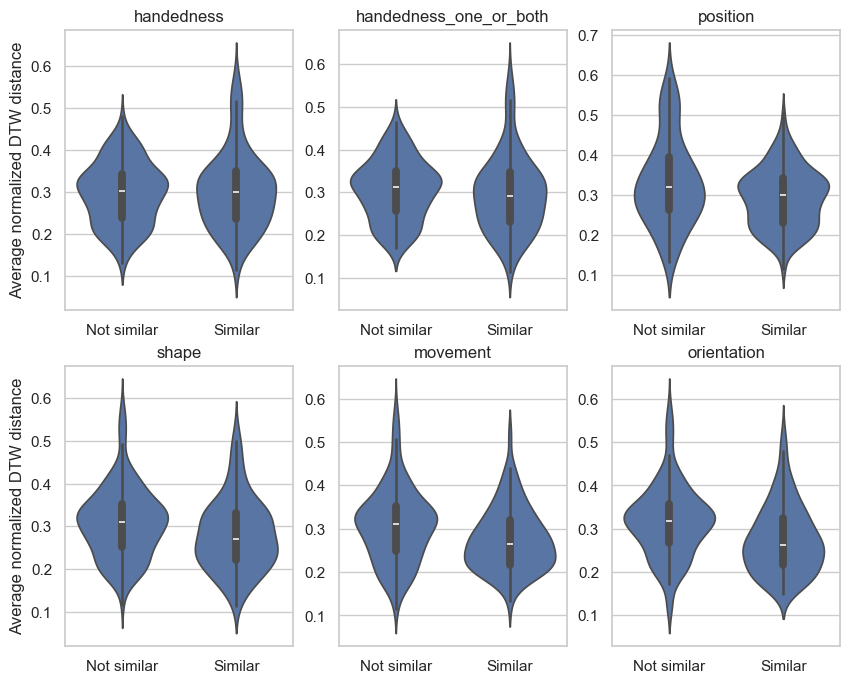

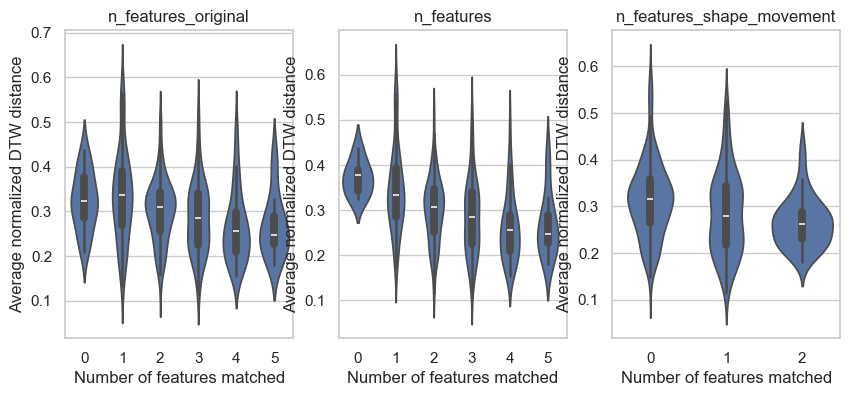

In [28]:
df_dtw_modified = pd.read_csv(dtw_modified_folder + "dtw_distance.csv")

### plot the average distance
print("====================" + "Average distance (no weight adjustment)" + "====================")
### plot the average distance for each feature
fig = plt.figure(figsize=(10, 8))
columns = 3
rows = 2
features = ["handedness", "handedness_one_or_both", "position", "shape", "movement", "orientation"]
plot_average_distance_feature(fig, columns, rows, features, df_dtw_modified)

### plot the average distance by the number of features matched
fig = plt.figure(figsize=(10, 4))
columns = 3
rows = 1
features = ["n_features_original", "n_features", "n_features_shape_movement"]
plot_average_distance_nfeatures(fig, columns, rows, features, df_dtw_modified)

### plot the duration
# print("====================" + "Duration difference" + "====================")
# plot_average_distance_dur_diff(df_dtw_modified)

# print("====================" + "Minimum duration" + "====================")
# plot_average_distance_dur(df_dtw_modified)

#### [Not used] z transformed average distance

====================Average distance (z-scored)====================


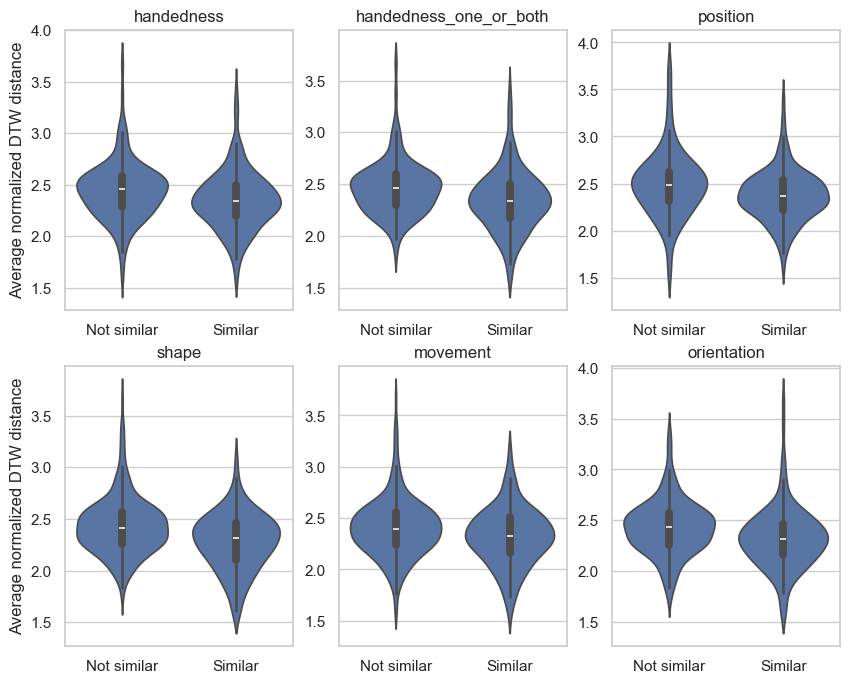

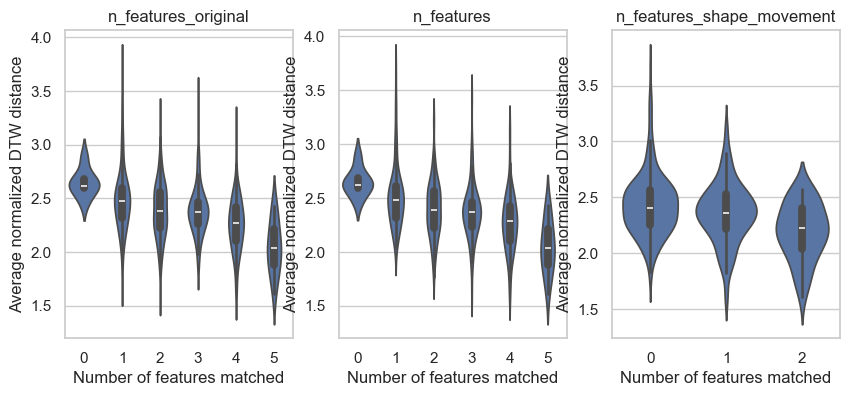

In [29]:
df_dtw_modified = pd.read_csv(dtw_modified_folder + "dtw_distance.csv")

### plot the average distance
print("====================" + "Average distance (z-scored)" + "====================")
### plot the average distance for each feature
fig = plt.figure(figsize=(10, 8))
columns = 3
rows = 2
features = ["handedness", "handedness_one_or_both", "position", "shape", "movement", "orientation"]
plot_average_distance_feature(fig, columns, rows, features, df_dtw_modified, y="average_distance_z")

### plot the average distance by the number of features matched
fig = plt.figure(figsize=(10, 4))
columns = 3
rows = 1
features = ["n_features_original", "n_features", "n_features_shape_movement"]
plot_average_distance_nfeatures(fig, columns, rows, features, df_dtw_modified, y="average_distance_z")

### plot the duration
# print("====================" + "Duration difference" + "====================")
# plot_average_distance_dur_diff(df_dtw_modified)

#### [Chosen] Average distance for all coordinates

====================Average distance (x,y,z)====================


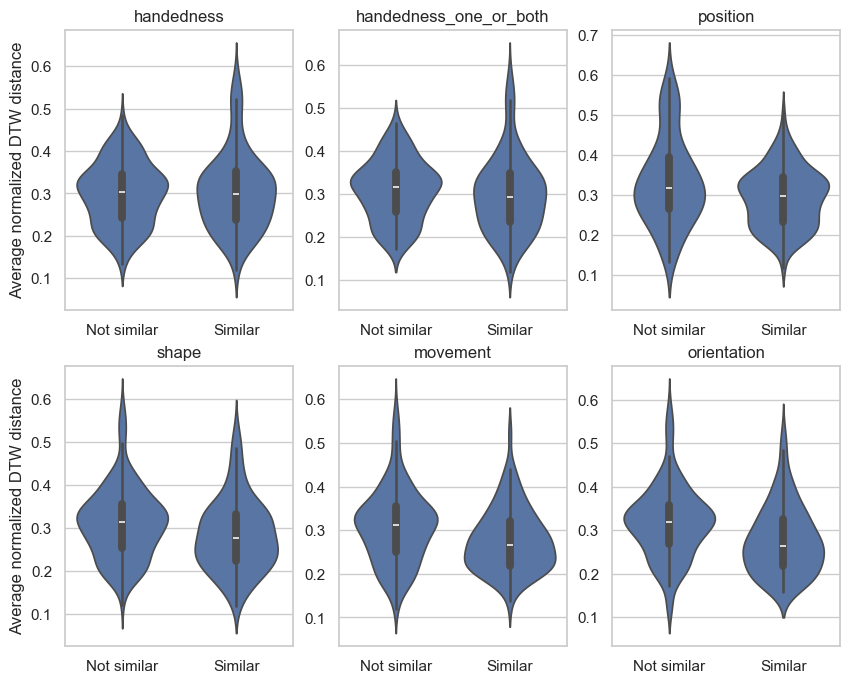

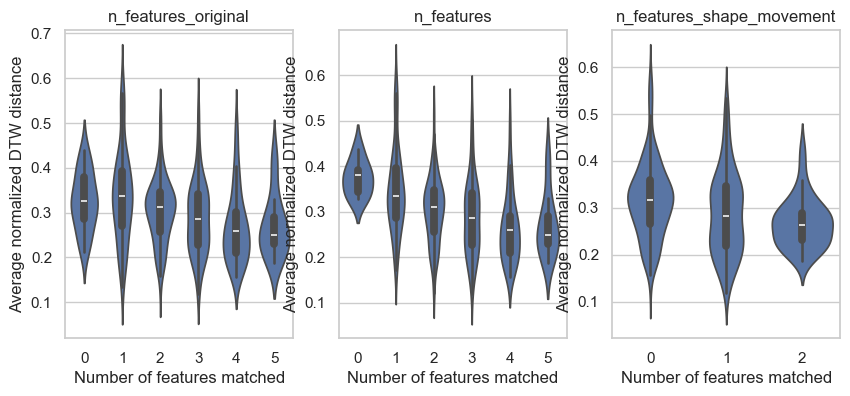

In [30]:
df_dtw_modified = pd.read_csv(dtw_modified_folder + "dtw_distance.csv")

### plot the average distance
print("====================" + "Average distance (x,y,z)" + "====================")
### plot the average distance for each feature
fig = plt.figure(figsize=(10, 8))
columns = 3
rows = 2
features = ["handedness", "handedness_one_or_both", "position", "shape", "movement", "orientation"]
plot_average_distance_feature(fig, columns, rows, features, df_dtw_modified, y="average_distance_xyz")

### plot the average distance by the number of features matched
fig = plt.figure(figsize=(10, 4))
columns = 3
rows = 1
features = ["n_features_original", "n_features", "n_features_shape_movement"]
plot_average_distance_nfeatures(fig, columns, rows, features, df_dtw_modified, y="average_distance_xyz")

### plot the duration
# print("====================" + "Duration difference" + "====================")
# plot_average_distance_dur_diff(df_dtw_modified)

#### [Not used] Average distance for all coordinates (z-scored)

====================Average distance (x,y,z)====================


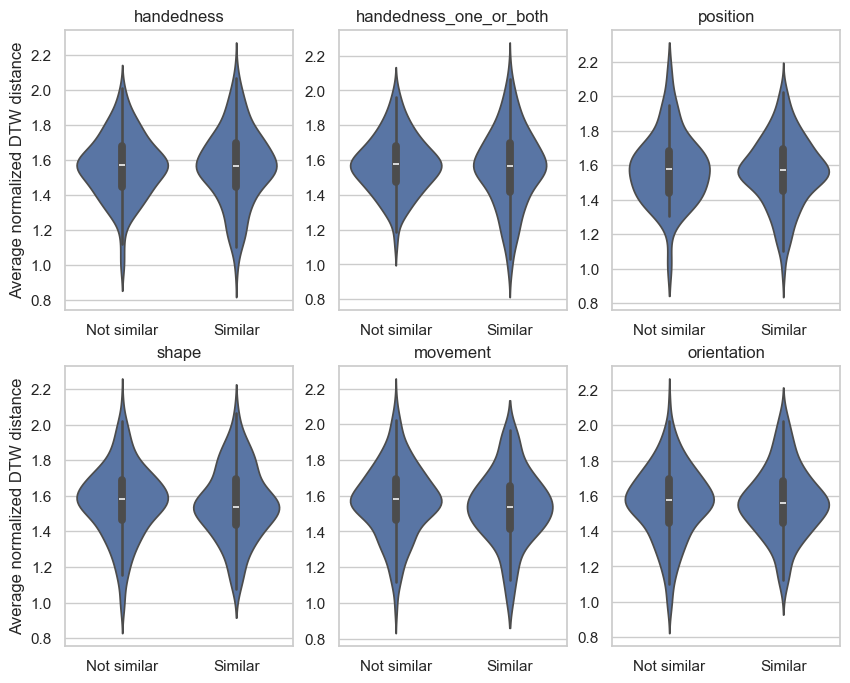

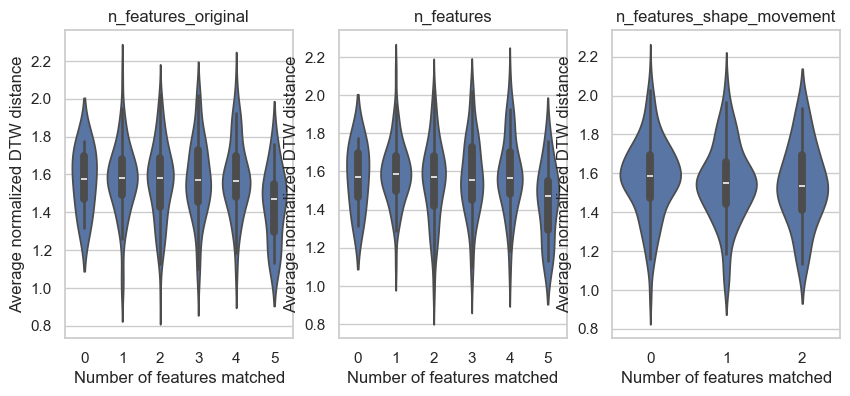

In [31]:
df_dtw_modified = pd.read_csv(dtw_modified_folder + "dtw_distance.csv")

### plot the average distance
print("====================" + "Average distance (x,y,z)" + "====================")
### plot the average distance for each feature
fig = plt.figure(figsize=(10, 8))
columns = 3
rows = 2
features = ["handedness", "handedness_one_or_both", "position", "shape", "movement", "orientation"]
plot_average_distance_feature(fig, columns, rows, features, df_dtw_modified, y="average_distance_xyz_z")

### plot the average distance by the number of features matched
fig = plt.figure(figsize=(10, 4))
columns = 3
rows = 1
features = ["n_features_original", "n_features", "n_features_shape_movement"]
plot_average_distance_nfeatures(fig, columns, rows, features, df_dtw_modified, y="average_distance_xyz_z")

### plot the duration
# print("====================" + "Duration difference" + "====================")
# plot_average_distance_dur_diff(df_dtw_modified)

#### [Not used] Adjusted finger positions

====================Minimum distance====================


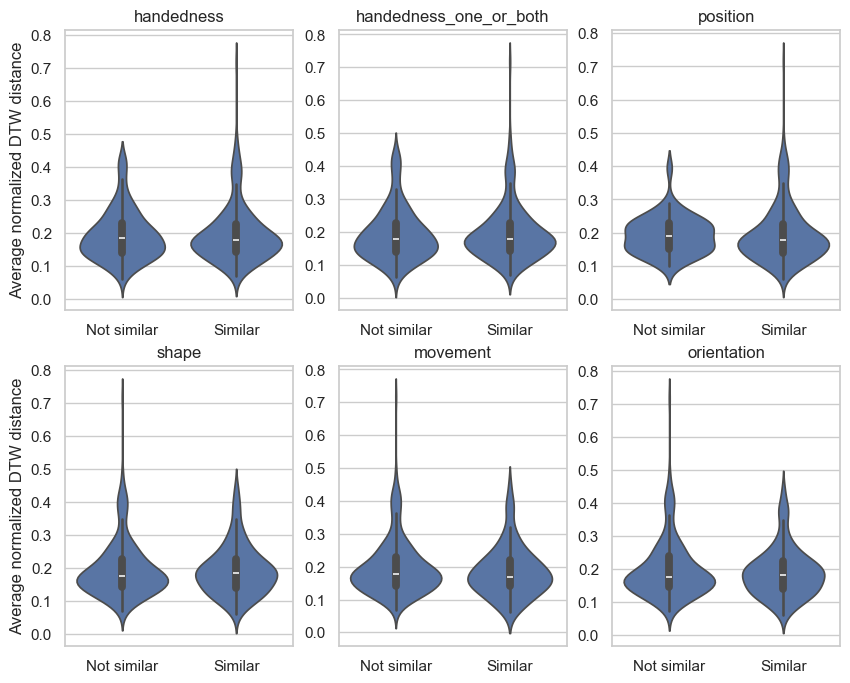

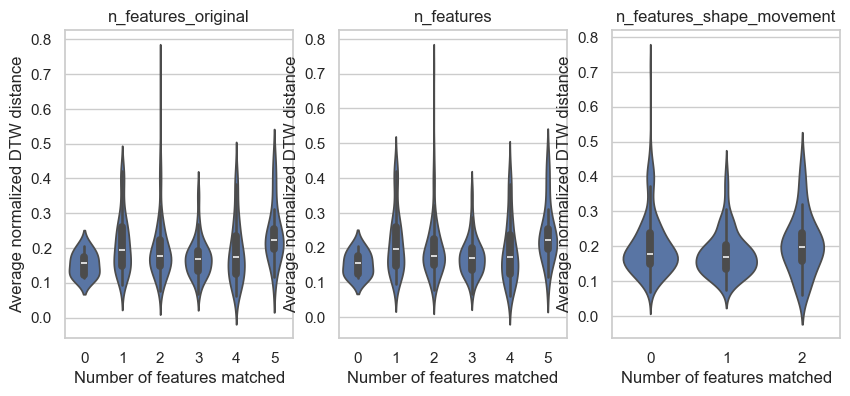

In [32]:
### plot the average distance
print("====================" + "Minimum distance" + "====================")
### plot the average distance for each feature
fig = plt.figure(figsize=(10, 8))
columns = 3
rows = 2
features = ["handedness", "handedness_one_or_both", "position", "shape", "movement", "orientation"]
plot_average_distance_feature(fig, columns, rows, features, df_dtw_modified, y="average_distance_adjusted")

### plot the average distance by the number of features matched
fig = plt.figure(figsize=(10, 4))
columns = 3
rows = 1
features = ["n_features_original", "n_features", "n_features_shape_movement"]
plot_average_distance_nfeatures(fig, columns, rows, features, df_dtw_modified, y="average_distance_adjusted")

#### [Not used] SMOP

====================Relative position (euclidian distance)====================


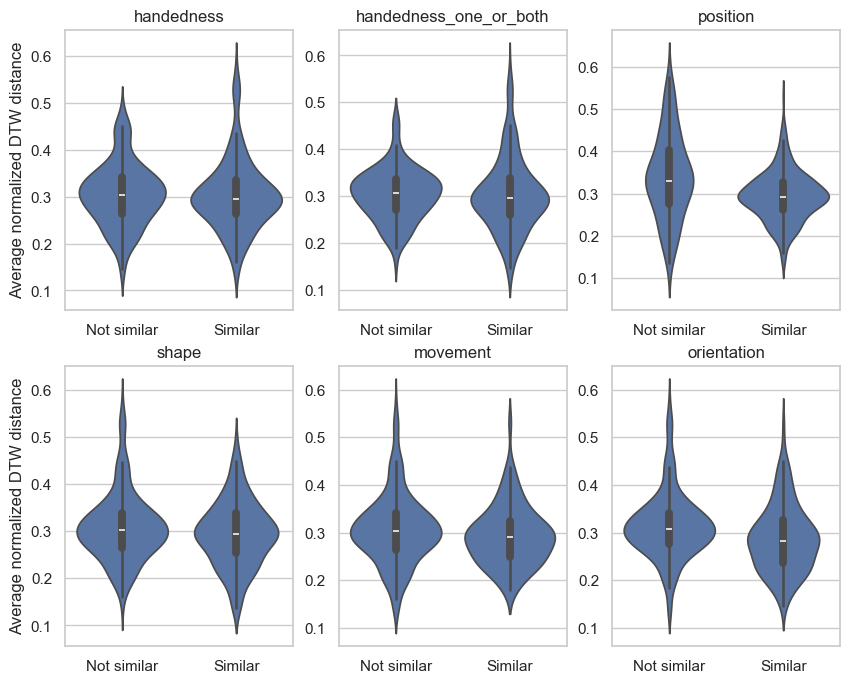

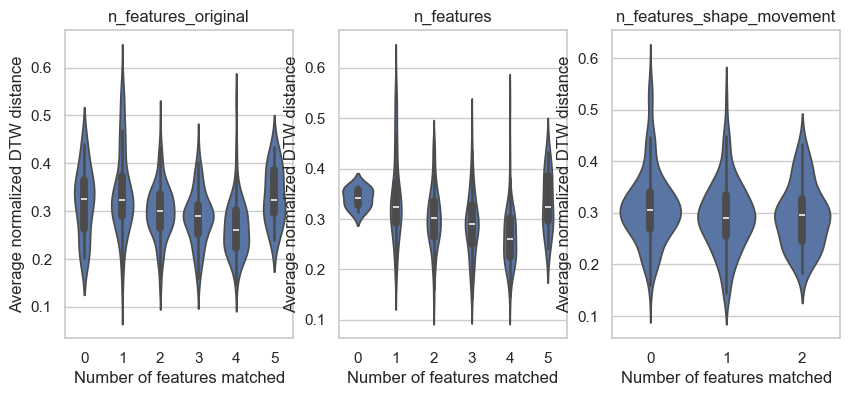

In [33]:
### plot the average distance
print("====================" + "Relative position (euclidian distance)" + "====================")
### plot the average distance for each feature
fig = plt.figure(figsize=(10, 8))
columns = 3
rows = 2
features = ["handedness", "handedness_one_or_both", "position", "shape", "movement", "orientation"]
plot_average_distance_feature(fig, columns, rows, features, df_dtw_modified, y="average_distance_smop")

### plot the average distance by the number of features matched
fig = plt.figure(figsize=(10, 4))
columns = 3
rows = 1
features = ["n_features_original", "n_features", "n_features_shape_movement"]
plot_average_distance_nfeatures(fig, columns, rows, features, df_dtw_modified, y="average_distance_smop")

Having compared average_distance and min_distance, it looks like average_distance provides us a better estimation of gesture form similarity. Also, we are mostly interested in the shape and movement features, and average_distance seems to capture the features better. 

Another comparison to consider is whether we should use the weighted ts or not. Based on the plots, they don't seem to differ significantly. Given that non-weighted ts has less preprocessing and thus closer to the original data, it seems a better choice.

So our pick is **average_distance based on non-weighted DTW**.

Finally, let's run some statistics to confirm that the distance for similar gesture pairs is lower than for not similar gesture pairs.

### Linear regression on DTW distance

#### Compare between xy and xyz

In [34]:
df_model = pd.read_csv(dtw_modified_folder + "dtw_distance.csv")
features = ["shape", "movement", "orientation"]
m1_dv = "average_distance"
m2_dv = "average_distance_xyz"

m1 = smf.ols(f"{m1_dv} ~ {"+".join(features)}", data=df_model)
m2 = smf.ols(f"{m2_dv} ~ {"+".join(features)}", data=df_model)
print(f"####### {m1_dv} #######")
print(m1.fit().summary())
print(f"####### {m2_dv} #######")
print(m2.fit().summary())

####### average_distance #######
                            OLS Regression Results                            
Dep. Variable:       average_distance   R-squared:                       0.077
Model:                            OLS   Adj. R-squared:                  0.070
Method:                 Least Squares   F-statistic:                     11.22
Date:                Thu, 15 May 2025   Prob (F-statistic):           4.37e-07
Time:                        00:07:59   Log-Likelihood:                 444.13
No. Observations:                 406   AIC:                            -880.3
Df Residuals:                     402   BIC:                            -864.2
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       0

The t values for xyz were higher than xy for all three features.

#### Compare between z transformed and non-transformed distance

In [35]:
df_model = pd.read_csv(dtw_modified_folder + "dtw_distance.csv")
features = ["handedness", "shape", "movement", "orientation", "position"]
m1_dv = "average_distance"
m2_dv = "average_distance_z"

m1 = smf.ols(f"{m1_dv} ~ {"+".join(features)}", data=df_model)
m2 = smf.ols(f"{m2_dv} ~ {"+".join(features)}", data=df_model)
print(f"####### {m1_dv} #######")
print(m1.fit().summary())
print(f"####### {m2_dv} #######")
print(m2.fit().summary())

####### average_distance #######
                            OLS Regression Results                            
Dep. Variable:       average_distance   R-squared:                       0.121
Model:                            OLS   Adj. R-squared:                  0.110
Method:                 Least Squares   F-statistic:                     11.05
Date:                Thu, 15 May 2025   Prob (F-statistic):           5.54e-10
Time:                        00:07:59   Log-Likelihood:                 454.06
No. Observations:                 406   AIC:                            -896.1
Df Residuals:                     400   BIC:                            -872.1
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       0

## Summary of the approach
Based on the plots and the linear regression, we decided to adopt the following approach:

1. Use the relative position between the wrist and a finger tip for DTW. This is to minimize the chance of inflating the distance due to different position (values). For example, imagine that we have front-view recordings for two speakers, and they produced the identical movements but in different positions. In this case, the pattern in ts will be identical, but the values will be different. As DTW is senstive not only to the pattern in ts but also the value itself, identical movements in different positions will be "penalized" and have a larger distance. This "penalty" will be multiplied if we use multiple joints, as each joint will be penalized, and the penalty adds up. By using the relative positions for each joints, only the wrist will be penalized.
1. Set the minimum duration as 330 ms (10 frames; 30 FPS). If the gesture stroke duration is less than 330ms, we will add equal interval before and after the stroke to make it 330ms long.
1. Only use the distance for gesturing hands when calculating the average distance.